In [649]:
from imblearn.ensemble import RUSBoostClassifier,BalancedBaggingClassifier,BalancedRandomForestClassifier
import sklearn as sk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,RepeatedKFold,GridSearchCV,RandomizedSearchCV ,StratifiedKFold,KFold
from sklearn.svm import LinearSVC , LinearSVR
from sklearn.metrics import mean_squared_error , f1_score ,accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef,auc,roc_auc_score,confusion_matrix,roc_curve,precision_recall_curve
from sklearn.svm import SVR
from sklearn.preprocessing import scale ,StandardScaler
from sklearn.feature_selection import SelectKBest, chi2 ,f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from xgboost import XGBClassifier ,XGBRFRegressor ,XGBRegressor
from rotation_forest import RotationTreeClassifier, RotationForestClassifier
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier,CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm

import random
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path
from imblearn.over_sampling import SMOTE
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,Normalizer,Binarizer
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
import time
from joblib import Parallel, delayed

#from lightgbm import LGBMClassifier,LGBMRegressor
from BorutaShap import BorutaShap, load_data
from sklearn.utils import shuffle
from catboost.utils import eval_metric
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import PredefinedSplit
from scipy import stats
from scipy.stats import randint

In [5]:
save_data_dir = r"C:\Users\12105\Desktop\HZ with gap\before_fs"
data_dir = r"C:\Users\12105\Desktop\HZ with gap\raw_data"
fi_dir = r"C:\Users\12105\Desktop\HZ with gap\fi"
os.chdir(data_dir)

In [6]:
def threshold(input,value):
    model = Binarizer(threshold=value)
    input = np.array(input)
    input = input.reshape(-1,1)
    output = model.transform(input)
    return output.flatten()


def Performance(ytrue,yhat,mag,region):
    tn , fp , fn , tp = confusion_matrix(ytrue,yhat).flatten()
    mcc = matthews_corrcoef(ytrue,yhat)
    f1 = f1_score(ytrue,yhat)
    acc = accuracy_score(ytrue,yhat)
    recall = recall_score(ytrue,yhat)
    precision = precision_score(ytrue,yhat)
    output = {"tn":tn,"fp":fp,"fn":fn,"tp":tp,"mcc":mcc,"f1":f1,"acc":acc,"recall":recall,"precision":precision,"mag":mag,"region":region}
    return output

scorefunction = make_scorer(matthews_corrcoef, greater_is_better=True)

def irrel_filter(Data, target):
    L=Data.shape[0]
    MI=[]
    cols=[]
    targ_norm = (target-target.min())/(target.max()-target.min())
    targ_med=targ_norm.median()
    targ_norm_bins = (targ_norm>targ_med).astype(int)
    for i in Data.columns:
        temp_norm = (Data[i]-Data[i].min())/(Data[i].max()-Data[i].min())
        med=temp_norm.median()
        temp_norm_bins = (temp_norm>med).astype(int)
        U = 2*temp_norm_bins+targ_norm_bins
        U0 = U[U==0].shape[0]
        U1 = U[U==1].shape[0]
        U2 = U[U==2].shape[0]
        U3 = U[U==3].shape[0]
        
        p_targ_0=(U0+U2)/L
        p_targ_1=(U1+U3)/L
        p_temp_0=(U0+U1)/L
        p_temp_1=(U2+U3)/L
        
        p_targ0_temp0=U0/L
        p_targ0_temp1=U2/L
        p_targ1_temp0=U1/L
        p_targ1_temp1=U3/L
        try:
            mi=p_targ0_temp0*np.log2(p_targ0_temp0/(p_targ_0*p_temp_0))+p_targ1_temp0*np.log2(p_targ1_temp0/(p_targ_1*p_temp_0))+p_targ0_temp1*np.log2(p_targ0_temp1/(p_targ_0*p_temp_1))+p_targ1_temp1*np.log2(p_targ1_temp1/(p_targ_1*p_temp_1))
        except ZeroDivisionError:
            mi=np.nan
        if np.isnan(mi)==True:
            mi=0
        if mi<0.001:
            mi=-1
        MI.append(mi)
        if mi==-1:
            cols.append(i)
    return MI, cols

def redundant_filter(Data,MI):
    L=Data.shape[0]
    RC=np.zeros((1,(Data.shape[1]-1)))
    first=np.zeros((1,(Data.shape[1]-1)))
    second=np.zeros((1,(Data.shape[1]-1)))
    cols=[]
    for i in range(Data.shape[1]-1):
        first_var=Data.iloc[:,i]
        first_norm=((first_var-first_var.min())/(first_var.max()-first_var.min()))
        med=first_norm.median()
        first_norm_bins=(first_norm>med).astype(int)
        for j in range((i+1),(Data.shape[1]-1)):
            sec_var=Data.iloc[:,j]
            sec_norm=((sec_var-sec_var.min())/(sec_var.max()-sec_var.min()))
            med=sec_norm.median()
            sec_norm_bins=(sec_norm>med).astype(int)
            U=2*sec_norm_bins+first_norm_bins
            U0 = U[U==0].shape[0]
            U1 = U[U==1].shape[0]
            U2 = U[U==2].shape[0]
            U3 = U[U==3].shape[0]
            
            p_first_0=(U0+U2)/L
            p_first_1=(U1+U3)/L
            p_sec_0=(U0+U1)/L
            p_sec_1=(U2+U3)/L

            p_first0_sec0=U0/L
            p_first0_sec1=U2/L
            p_first1_sec0=U1/L
            p_first1_sec1=U3/L
            try:
                Mut_Inf_temp=p_first0_sec0*np.log2(p_first0_sec0/(p_first_0*p_sec_0))+p_first1_sec0*np.log2(p_first1_sec0/(p_first_1*p_sec_0))+p_first0_sec1*np.log2(p_first0_sec1/(p_first_0*p_sec_1))+p_first1_sec1*np.log2(p_first1_sec1/(p_first_1*p_sec_1))
            except ZeroDivisionError:
                Mut_Inf_temp=np.nan
            if np.isnan(Mut_Inf_temp)==True:
                Mut_Inf_temp=0
            if Mut_Inf_temp>RC[0, i]:
                RC[0, i]=Mut_Inf_temp
                first[0, i]=i
                second[0, i]=j
        if RC[0, i]>0.2:
            if MI[(first[0, i]).astype(int)]>MI[(second[0, i]).astype(int)]:
                drop_ind=second[0, i]
            else:
                drop_ind=first[0, i]
        cols.append(Data.columns[drop_ind.astype(int)])
    cols = list(set(cols))
    return cols, RC




def model_result(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=0.3,shuffle=False)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result



def model_result2(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=0.3,shuffle=False)
    X_train ,y_train= X_train[:-25] , y_train[:-25]
    X_test,y_test = X_test.iloc[25:],y_test[25:]
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result

def model_result_mrmr(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,shuffle=False)

    MI1,cols = irrel_filter(X_train,y_train)
    cols2,RC = redundant_filter(X_train,MI=MI1)
    coldrop = cols2+cols

    X_train.drop(coldrop,axis=1,inplace=True)
    X_test.drop(coldrop,axis=1,inplace=True)

    y_train = threshold(y_train,thr_mag)
    y_test = threshold(y_test,thr_mag)
    
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    result = Performance(yhat,y_test,mag=thr_mag,region=regionname)
    print(result)
    return result


def boruta_data_creator(model,geodata,n_trials,featype = "shap",savename = "fi_.csv"):
	
	geodata.dropna(inplace=True)
	x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
	X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,shuffle=False)

	Feature_Selector = BorutaShap(importance_measure=featype,
								classification=False,model=model)
	Feature_Selector.fit(X=X_train, y=y_train, n_trials=n_trials, sample=False,
						train_or_test = 'test', normalize=True,
				verbose=True)
	feaset = Feature_Selector.accepted +  Feature_Selector.tentative
	Feature_Selector.results_to_csv(filename=savename)

	print(feaset)
	return geodata[feaset]


def randomsearch(model,geodata,thr_mag,regionname,para1,param_grid,modelname):
    geodata.dropna(inplace=True)

    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    y = threshold(y,thr_mag)
    X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3,shuffle=False)

    model.set_params(**para1)
    split_index = [-1 if x in X_train.index else 0 for x in x.index]
    pds = PredefinedSplit(test_fold = split_index)

    clf = RandomizedSearchCV(estimator = model,
                   cv=pds,
                   param_distributions =param_grid)
    clf.fit(x, y)

    best_parameter = clf.best_params_
    model.set_params(**best_parameter)
    
    result = model_result(model,geodata,thr_mag,regionname)

    return [result , {"best_para":best_parameter,"model_name":modelname,"regionname":regionname,"mag":thr_mag}]


def gridsearch(model,geodata,thr_mag,regionname,para1,param_grid,modelname):
    geodata.dropna(inplace=True)

    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    y = threshold(y,thr_mag)
    X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3,shuffle=False)

    model.set_params(**para1)
    split_index = [-1 if x in X_train.index else 0 for x in x.index]
    pds = PredefinedSplit(test_fold = split_index)

    clf = GridSearchCV(estimator = model,
                   cv=pds,scoring = scorefunction,
                   param_grid =param_grid)
    clf.fit(x, y)

    best_parameter = clf.best_params_
    model.set_params(**best_parameter)
    
    result = model_result(model,geodata,thr_mag,regionname)

    return [result , {"best_para":best_parameter,"model_name":modelname,"regionname":regionname,"mag":thr_mag}]


def grid2search(model,geodata,thr_mag,regionname,para1,param_grid,modelname):
    geodata.dropna(inplace=True)

    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    y = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,shuffle=False)
    
    X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train,test_size=0.3,shuffle=False)

    model.set_params(**para1)
    split_index = [-1 if x in X_train1.index else 0 for x in X_train.index]
    pds = PredefinedSplit(test_fold = split_index)

    clf = GridSearchCV(estimator = model,
                   cv=pds,
                   param_grid= param_grid)
    clf.fit(X_train, y_train)

    best_parameter = clf.best_params_
    model.set_params(**best_parameter)
    model.set_params(**para1)
    
    result = model_result(model,geodata,thr_mag,regionname)

    return [result , {"best_para":best_parameter,"model_name":modelname,"regionname":regionname,"mag":thr_mag}]


def model_result2(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=0.31,shuffle=False)
    X_train ,y_train= X_train[:-25] , y_train[:-25]   
    X_test ,y_test= X_test[25:] , y_test[25:]
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result

def grid3search(model,geodata,thr_mag,regionname,para1,param_grid,modelname):
    geodata.dropna(inplace=True)

    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    y = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.31,shuffle=False)
    X_train ,y_train= X_train[:-25] , y_train[:-25]   
    X_test ,y_test= X_test[25:] , y_test[25:]

    X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train,test_size=0.3,shuffle=False)

    model.set_params(**para1)
    split_index = [-1 if x in X_train1.index else 0 for x in X_train.index]
    pds = PredefinedSplit(test_fold = split_index)

    clf = GridSearchCV(estimator = model,
                   cv=pds,
                   param_grid= param_grid)
    clf.fit(X_train, y_train)

    best_parameter = clf.best_params_
    model.set_params(**best_parameter)
    model.set_params(**para1)
    
    result = model_result2(model,geodata,thr_mag,regionname)

    return [result , {"best_para":best_parameter,"model_name":modelname,"regionname":regionname,"mag":thr_mag}]


In [69]:
os.chdir(data_dir)
chile_data = pd.read_csv("CH.csv")
sc_data = pd.read_csv("SC2.csv")
Hindu_data = pd.read_csv("H2.csv")

In [178]:
base_xg = XGBClassifier()
param_grid = {'n_estimators': [500,2000,1000,3000],
             # 'learning_rate': [0.08,0.1],#0.01,0.02,0.05],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              #'max_depth': [3, 4, 5, 6, 7, 8, 9],
              #'colsample_bytree': [0.6,0.7,0.9],
              #'min_child_weight': [1, 2, 3, 4],
              #"gamma":[0.1,0,0.5,1],
              "max_depth":[4,6,8]
             }

para1 = {"eval_metric":matthews_corrcoef}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = XGBClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,sc_data,i,"SC",para1=para1,param_grid=param_grid,modelname="XG")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("SC_XG.csv")
model_detail.to_csv("SC_XG_modelpara.csv")
H_mcc





H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = XGBClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,chile_data,i,"CH",para1=para1,param_grid=param_grid,modelname="XG")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("CH_XG.csv")
model_detail.to_csv("CH_XG_modelpara.csv")
H_mcc






base_xg = XGBClassifier()
param_grid = {'n_estimators': [500,2000,1000,3000],
             # 'learning_rate': [0.08,0.1],#0.01,0.02,0.05],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              #'max_depth': [3, 4, 5, 6, 7, 8, 9],
              #'colsample_bytree': [0.6,0.7,0.9],
              #'min_child_weight': [1, 2, 3, 4],
              #"gamma":[0.1,0,0.5,1],
              "max_depth":[4,6,8]
             }

para1 = {"eval_metric":matthews_corrcoef}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = XGBClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="XG")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_XG.csv")
model_detail.to_csv("H_XG_modelpara.csv")
H_mcc

{'tn': 7078, 'fp': 880, 'fn': 698, 'tp': 350, 'mcc': 0.20859963837394999, 'f1': 0.30728709394205445, 'acc': 0.8247834776815456, 'recall': 0.33396946564885494, 'precision': 0.2845528455284553, 'mag': 5, 'region': 'SC'}
{'tn': 8346, 'fp': 477, 'fn': 169, 'tp': 14, 'mcc': 0.013944840921489607, 'f1': 0.04154302670623146, 'acc': 0.9282700421940928, 'recall': 0.07650273224043716, 'precision': 0.028513238289205704, 'mag': 5.5, 'region': 'SC'}
{'tn': 8951, 'fp': 9, 'fn': 43, 'tp': 3, 'mcc': 0.12548399098050123, 'f1': 0.10344827586206896, 'acc': 0.9942260715078837, 'recall': 0.06521739130434782, 'precision': 0.25, 'mag': 6, 'region': 'SC'}
{'tn': 8974, 'fp': 3, 'fn': 29, 'tp': 0, 'mcc': -0.001037529344291134, 'f1': 0.0, 'acc': 0.9964468132356207, 'recall': 0.0, 'precision': 0.0, 'mag': 6.5, 'region': 'SC'}
{'tn': 8971, 'fp': 6, 'fn': 29, 'tp': 0, 'mcc': -0.0014675325976926568, 'f1': 0.0, 'acc': 0.9961137019764601, 'recall': 0.0, 'precision': 0.0, 'mag': 7, 'region': 'SC'}
{'tn': 1416, 'fp': 21,

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,746,216,302,61,-0.061955,0.190625,0.609057,0.168044,0.220217,5.0,H
1,1132,62,115,16,0.089035,0.153110,0.866415,0.122137,0.205128,5.5,H
2,1280,9,29,7,0.279037,0.269231,0.971321,0.194444,0.437500,6.0,H
3,1296,1,26,2,0.213812,0.129032,0.979623,0.071429,0.666667,6.5,H
4,1318,0,6,1,0.377107,0.250000,0.995472,0.142857,1.000000,7.0,H


In [224]:
base_xg = XGBClassifier()
param_grid = {'n_estimators': [500,2000,1000,3000],
             # 'learning_rate': [0.08,0.1],#0.01,0.02,0.05],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              #'max_depth': [3, 4, 5, 6, 7, 8, 9],
              #'colsample_bytree': [0.6,0.7,0.9],
              #'min_child_weight': [1, 2, 3, 4],
              #"gamma":[0.1,0,0.5,1],
              "max_depth":[4,6,8]
             }

para1 = {"eval_metric":matthews_corrcoef}

H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = XGBClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="XG")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_XG.csv")
model_detail.to_csv("H_XG_modelpara.csv")
H_mcc

{'tn': 709, 'fp': 258, 'fn': 272, 'tp': 86, 'mcc': -0.026922398827596273, 'f1': 0.24501424501424499, 'acc': 0.6, 'recall': 0.24022346368715083, 'precision': 0.25, 'mag': 5, 'region': 'H'}
{'tn': 1149, 'fp': 45, 'fn': 114, 'tp': 17, 'mcc': 0.13014204579601937, 'f1': 0.17616580310880828, 'acc': 0.88, 'recall': 0.1297709923664122, 'precision': 0.27419354838709675, 'mag': 5.5, 'region': 'H'}
{'tn': 1279, 'fp': 10, 'fn': 26, 'tp': 10, 'mcc': 0.36004195254913685, 'f1': 0.35714285714285715, 'acc': 0.9728301886792453, 'recall': 0.2777777777777778, 'precision': 0.5, 'mag': 6, 'region': 'H'}
{'tn': 1297, 'fp': 0, 'fn': 26, 'tp': 2, 'mcc': 0.26462206130811883, 'f1': 0.13333333333333333, 'acc': 0.9803773584905661, 'recall': 0.07142857142857142, 'precision': 1.0, 'mag': 6.5, 'region': 'H'}
{'tn': 1318, 'fp': 0, 'fn': 6, 'tp': 1, 'mcc': 0.37710708557680445, 'f1': 0.25, 'acc': 0.9954716981132076, 'recall': 0.14285714285714285, 'precision': 1.0, 'mag': 7, 'region': 'H'}


,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,709,258,272,86,-0.026922,0.245014,0.600000,0.240223,0.250000,5.0,H
1,1149,45,114,17,0.130142,0.176166,0.880000,0.129771,0.274194,5.5,H
2,1279,10,26,10,0.360042,0.357143,0.972830,0.277778,0.500000,6.0,H
3,1297,0,26,2,0.264622,0.133333,0.980377,0.071429,1.000000,6.5,H
4,1318,0,6,1,0.377107,0.250000,0.995472,0.142857,1.000000,7.0,H


In [179]:
param_grid = {"n_estimators":[300,500,1000],
                #"learning_rate":[0.1,0.01,0.05],
                }

para1 = {}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RUSBoostClassifier(estimator=DecisionTreeClassifier())
    result_ch_xg , ch_xg_detail = grid3search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="rus")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_rus.csv")
model_detail.to_csv("H_rus_modelpara.csv")
H_mcc




H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RUSBoostClassifier(estimator=DecisionTreeClassifier())
    result_ch_xg , ch_xg_detail = grid3search(base_model,chile_data,i,"CH",para1=para1,param_grid=param_grid,modelname="rus")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("CH_rus.csv")
model_detail.to_csv("CH_rus_modelpara.csv")
H_mcc




H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RUSBoostClassifier(estimator=DecisionTreeClassifier())
    result_ch_xg , ch_xg_detail = grid3search(base_model,sc_data,i,"SC",para1=para1,param_grid=param_grid,modelname="rus")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("SC_rus.csv")
model_detail.to_csv("SC_rus_modelpara.csv")
H_mcc

{'tn': 910, 'fp': 52, 'fn': 334, 'tp': 29, 'mcc': 0.04809603496238287, 'f1': 0.13063063063063066, 'acc': 0.7086792452830188, 'recall': 0.07988980716253444, 'precision': 0.35802469135802467, 'mag': 5, 'region': 'H'}
{'tn': 1172, 'fp': 22, 'fn': 123, 'tp': 8, 'mcc': 0.08556428214583012, 'f1': 0.09937888198757765, 'acc': 0.8905660377358491, 'recall': 0.061068702290076333, 'precision': 0.26666666666666666, 'mag': 5.5, 'region': 'H'}
{'tn': 1234, 'fp': 55, 'fn': 28, 'tp': 8, 'mcc': 0.13717393593408084, 'f1': 0.16161616161616163, 'acc': 0.9373584905660377, 'recall': 0.2222222222222222, 'precision': 0.12698412698412698, 'mag': 6, 'region': 'H'}
{'tn': 1276, 'fp': 21, 'fn': 27, 'tp': 1, 'mcc': 0.021974230876497185, 'f1': 0.04, 'acc': 0.9637735849056603, 'recall': 0.03571428571428571, 'precision': 0.045454545454545456, 'mag': 6.5, 'region': 'H'}
{'tn': 1257, 'fp': 61, 'fn': 3, 'tp': 4, 'mcc': 0.17625648517375642, 'f1': 0.11111111111111112, 'acc': 0.9516981132075472, 'recall': 0.5714285714285714

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,7346,612,834,214,0.141425,0.228388,0.839440,0.204198,0.259080,5.0,SC
1,8678,145,172,11,0.047232,0.064897,0.964801,0.060109,0.070513,5.5,SC
2,8928,32,46,0,-0.004279,0.000000,0.991339,0.000000,0.000000,6.0,SC
3,8962,15,25,4,0.168248,0.166667,0.995559,0.137931,0.210526,6.5,SC
4,8924,53,21,8,0.186469,0.177778,0.991783,0.275862,0.131148,7.0,SC


In [225]:
param_grid = {"n_estimators":[300,500,1000],
                #"learning_rate":[0.1,0.01,0.05],
                }

para1 = {}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RUSBoostClassifier(estimator=DecisionTreeClassifier())
    result_ch_xg , ch_xg_detail = grid3search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="rus")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_rus.csv")
model_detail.to_csv("H_rus_modelpara.csv")
H_mcc

{'tn': 902, 'fp': 65, 'fn': 309, 'tp': 49, 'mcc': 0.11029910756119184, 'f1': 0.2076271186440678, 'acc': 0.7177358490566038, 'recall': 0.13687150837988826, 'precision': 0.4298245614035088, 'mag': 5, 'region': 'H'}
{'tn': 1138, 'fp': 56, 'fn': 115, 'tp': 16, 'mcc': 0.09906564346733318, 'f1': 0.15763546798029557, 'acc': 0.8709433962264151, 'recall': 0.12213740458015267, 'precision': 0.2222222222222222, 'mag': 5.5, 'region': 'H'}
{'tn': 1273, 'fp': 16, 'fn': 31, 'tp': 5, 'mcc': 0.16464098564534763, 'f1': 0.17543859649122806, 'acc': 0.9645283018867925, 'recall': 0.1388888888888889, 'precision': 0.23809523809523808, 'mag': 6, 'region': 'H'}
{'tn': 1281, 'fp': 16, 'fn': 26, 'tp': 2, 'mcc': 0.07341869615299818, 'f1': 0.08695652173913043, 'acc': 0.9683018867924529, 'recall': 0.07142857142857142, 'precision': 0.1111111111111111, 'mag': 6.5, 'region': 'H'}
{'tn': 1284, 'fp': 34, 'fn': 3, 'tp': 4, 'mcc': 0.2369874862142248, 'f1': 0.17777777777777778, 'acc': 0.9720754716981133, 'recall': 0.57142857

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,902,65,309,49,0.110299,0.207627,0.717736,0.136872,0.429825,5.0,H
1,1138,56,115,16,0.099066,0.157635,0.870943,0.122137,0.222222,5.5,H
2,1273,16,31,5,0.164641,0.175439,0.964528,0.138889,0.238095,6.0,H
3,1281,16,26,2,0.073419,0.086957,0.968302,0.071429,0.111111,6.5,H
4,1284,34,3,4,0.236987,0.177778,0.972075,0.571429,0.105263,7.0,H


In [226]:
param_grid = {'n_estimators': [300,800,1400,2000],
              'learning_rate': [0.1,0.05,0.01],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              'depth': [4 ],
              #"l2_leaf_reg":[3,10,5,0,1],
             }

para1 = {"eval_metric":"MCC",
         "auto_class_weights":"Balanced",
         "verbose":False,
         "early_stopping_rounds":50}

H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = CatBoostClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="cat")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_cat.csv")
model_detail.to_csv("H_cat_modelpara.csv")
print(H_mcc)

{'tn': 636, 'fp': 331, 'fn': 248, 'tp': 110, 'mcc': -0.03301330549078686, 'f1': 0.2753441802252816, 'acc': 0.5630188679245283, 'recall': 0.30726256983240224, 'precision': 0.2494331065759637, 'mag': 5, 'region': 'H'}
{'tn': 1092, 'fp': 102, 'fn': 107, 'tp': 24, 'mcc': 0.09949205711816267, 'f1': 0.1867704280155642, 'acc': 0.8422641509433962, 'recall': 0.183206106870229, 'precision': 0.19047619047619047, 'mag': 5.5, 'region': 'H'}
{'tn': 1241, 'fp': 48, 'fn': 25, 'tp': 11, 'mcc': 0.2114869945131354, 'f1': 0.23157894736842105, 'acc': 0.9449056603773585, 'recall': 0.3055555555555556, 'precision': 0.1864406779661017, 'mag': 6, 'region': 'H'}
{'tn': 1294, 'fp': 3, 'fn': 23, 'tp': 5, 'mcc': 0.32723589987906354, 'f1': 0.2777777777777778, 'acc': 0.9803773584905661, 'recall': 0.17857142857142858, 'precision': 0.625, 'mag': 6.5, 'region': 'H'}
{'tn': 1317, 'fp': 1, 'fn': 2, 'tp': 5, 'mcc': 0.7704050252851519, 'f1': 0.7692307692307692, 'acc': 0.9977358490566037, 'recall': 0.7142857142857143, 'preci

In [180]:
param_grid = {'n_estimators': [500,1000,2000],
              'learning_rate': [0.05,0.01,0.1],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              'depth': [4 ,6, 8],
              #"l2_leaf_reg":[3,10,5,0,1],
             }

para1 = {"eval_metric":"MCC",
         "auto_class_weights":"Balanced",
         "verbose":False,
         "early_stopping_rounds":50}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = CatBoostClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,sc_data,i,"SC",para1=para1,param_grid=param_grid,modelname="cat")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("SC_cat.csv")
model_detail.to_csv("SC_cat_modelpara.csv")
print(H_mcc)


H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = CatBoostClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,chile_data,i,"CH",para1=para1,param_grid=param_grid,modelname="cat")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("CH_cat.csv")
model_detail.to_csv("CH_cat_modelpara.csv")
print(H_mcc)



H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_xg = CatBoostClassifier()
    result_ch_xg , ch_xg_detail = grid3search(base_xg,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="cat")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_cat.csv")
model_detail.to_csv("H_cat_modelpara.csv")
print(H_mcc)

{'tn': 6918, 'fp': 1040, 'fn': 816, 'tp': 232, 'mcc': 0.08350000935431164, 'f1': 0.2, 'acc': 0.7939151676660005, 'recall': 0.22137404580152673, 'precision': 0.18238993710691823, 'mag': 5, 'region': 'SC'}
{'tn': 8483, 'fp': 340, 'fn': 135, 'tp': 48, 'mcc': 0.1554876631285232, 'f1': 0.1681260945709282, 'acc': 0.9472573839662447, 'recall': 0.26229508196721313, 'precision': 0.12371134020618557, 'mag': 5.5, 'region': 'SC'}
{'tn': 8900, 'fp': 60, 'fn': 28, 'tp': 18, 'mcc': 0.2958875902130417, 'f1': 0.2903225806451613, 'acc': 0.9902287363979569, 'recall': 0.391304347826087, 'precision': 0.23076923076923078, 'mag': 6, 'region': 'SC'}
{'tn': 8937, 'fp': 40, 'fn': 9, 'tp': 20, 'mcc': 0.4771901559425203, 'f1': 0.449438202247191, 'acc': 0.9945591827670442, 'recall': 0.6896551724137931, 'precision': 0.3333333333333333, 'mag': 6.5, 'region': 'SC'}
{'tn': 8899, 'fp': 78, 'fn': 8, 'tp': 21, 'mcc': 0.3887406935735999, 'f1': 0.328125, 'acc': 0.9904508105707306, 'recall': 0.7241379310344828, 'precision':

In [181]:
param_grid = {'max_depth': [8,6,4],
              'learning_rate': [0.05,0.01,0.1],
                'num_boost_round': [500,800,1000,2000]
                }

para1 = {#'is_unbalance':False,
            #"metric":"MCC"
            }
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = LGBMClassifier()
    result_ch_xg , ch_xg_detail = grid2search(base_model,sc_data,i,"SC",para1=para1,param_grid=param_grid,modelname="gbm")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("SC_gbm.csv")
model_detail.to_csv("SC_gbm_modelpara.csv")
H_mcc


H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = LGBMClassifier()
    result_ch_xg , ch_xg_detail = grid2search(base_model,chile_data,i,"CH",para1=para1,param_grid=param_grid,modelname="gbm")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("CH_gbm.csv")
model_detail.to_csv("CH_gbm_modelpara.csv")
H_mcc


H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = LGBMClassifier()
    result_ch_xg , ch_xg_detail = grid2search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="gbm")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_gbm.csv")
model_detail.to_csv("H_gbm_modelpara.csv")
H_mcc

[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations 

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,773,170,312,51,-0.047529,0.174658,0.630934,0.140496,0.230769,5.0,H
1,1154,21,126,5,0.043648,0.063694,0.887443,0.038168,0.192308,5.5,H
2,1270,0,33,3,0.284996,0.153846,0.974732,0.083333,1.000000,6.0,H
3,1278,0,26,2,0.264583,0.133333,0.980092,0.071429,1.000000,6.5,H
4,1298,1,5,2,0.434591,0.400000,0.995406,0.285714,0.666667,7.0,H


In [227]:
param_grid = {'max_depth': [8,6,4],
              'learning_rate': [0.05,0.01,0.1],
                'num_boost_round': [500,800,1000,2000]
                }

para1 = {#'is_unbalance':False,
            "metric":"MCC"
            }
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = LGBMClassifier()
    result_ch_xg , ch_xg_detail = grid2search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="gbm")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_gbm.csv")
model_detail.to_csv("H_gbm_modelpara.csv")
H_mcc

[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] num_iterations 

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,671,278,259,98,-0.018141,0.267394,0.588821,0.274510,0.260638,5.0,H
1,1159,16,128,3,0.023292,0.040000,0.889740,0.022901,0.157895,5.5,H
2,1270,0,33,3,0.284996,0.153846,0.974732,0.083333,1.000000,6.0,H
3,1277,1,25,3,0.278797,0.187500,0.980092,0.107143,0.750000,6.5,H
4,1298,1,5,2,0.434591,0.400000,0.995406,0.285714,0.666667,7.0,H


In [182]:
param_grid = {'max_depth': [4,8,6],
                "n_estimators":[300,500,1000]
                }

para1 = {"n_features_per_subset":60}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RotationForestClassifier(n_jobs=-1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="rot")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_rot.csv")
model_detail.to_csv("H_rot_modelpara.csv")
H_mcc



H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RotationForestClassifier(n_jobs=-1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,chile_data,i,"CH",para1=para1,param_grid=param_grid,modelname="rot")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("CH_rot.csv")
model_detail.to_csv("CH_rot_modelpara.csv")
H_mcc



H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RotationForestClassifier(n_jobs=-1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,sc_data,i,"SC",para1=para1,param_grid=param_grid,modelname="rot")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("SC_rot.csv")
model_detail.to_csv("SC_rot_modelpara.csv")
H_mcc

{'tn': 594, 'fp': 368, 'fn': 236, 'tp': 127, 'mcc': -0.030123341841596474, 'f1': 0.296037296037296, 'acc': 0.5441509433962264, 'recall': 0.349862258953168, 'precision': 0.25656565656565655, 'mag': 5, 'region': 'H'}
{'tn': 1184, 'fp': 10, 'fn': 130, 'tp': 1, 'mcc': -0.0024396422887589197, 'f1': 0.01408450704225352, 'acc': 0.8943396226415095, 'recall': 0.007633587786259542, 'precision': 0.09090909090909091, 'mag': 5.5, 'region': 'H'}
{'tn': 996, 'fp': 293, 'fn': 11, 'tp': 25, 'mcc': 0.1778251457295079, 'f1': 0.14124293785310735, 'acc': 0.7705660377358491, 'recall': 0.6944444444444444, 'precision': 0.07861635220125786, 'mag': 6, 'region': 'H'}
{'tn': 1297, 'fp': 0, 'fn': 28, 'tp': 0, 'mcc': 0.0, 'f1': 0.0, 'acc': 0.9788679245283018, 'recall': 0.0, 'precision': 0.0, 'mag': 6.5, 'region': 'H'}
{'tn': 1317, 'fp': 1, 'fn': 7, 'tp': 0, 'mcc': -0.002002844915810039, 'f1': 0.0, 'acc': 0.9939622641509434, 'recall': 0.0, 'precision': 0.0, 'mag': 7, 'region': 'H'}
{'tn': 1361, 'fp': 76, 'fn': 416, 

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,6996,962,816,232,0.095021,0.206958,0.802576,0.221374,0.194305,5.0,SC
1,8353,470,178,5,-0.016379,0.015198,0.928048,0.027322,0.010526,5.5,SC
2,8944,16,46,0,-0.003023,0.000000,0.993116,0.000000,0.000000,6.0,SC
3,8975,2,29,0,-0.000847,0.000000,0.996558,0.000000,0.000000,6.5,SC
4,8968,9,18,11,0.455315,0.448980,0.997002,0.379310,0.550000,7.0,SC


In [228]:
param_grid = {'max_depth': [4,8,6],
                "n_estimators":[300,500,1000]
                }

para1 = {"n_features_per_subset":60}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RotationForestClassifier(n_jobs=-1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="rot")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_rot.csv")
model_detail.to_csv("H_rot_modelpara.csv")
H_mcc


{'tn': 734, 'fp': 233, 'fn': 270, 'tp': 88, 'mcc': 0.005035607462700379, 'f1': 0.2592047128129602, 'acc': 0.6203773584905661, 'recall': 0.24581005586592178, 'precision': 0.27414330218068533, 'mag': 5, 'region': 'H'}
{'tn': 1097, 'fp': 97, 'fn': 118, 'tp': 13, 'mcc': 0.01946955863590139, 'f1': 0.1078838174273859, 'acc': 0.8377358490566038, 'recall': 0.09923664122137404, 'precision': 0.11818181818181818, 'mag': 5.5, 'region': 'H'}
{'tn': 1239, 'fp': 50, 'fn': 36, 'tp': 0, 'mcc': -0.03309441445824153, 'f1': 0.0, 'acc': 0.9350943396226415, 'recall': 0.0, 'precision': 0.0, 'mag': 6, 'region': 'H'}
{'tn': 1289, 'fp': 8, 'fn': 25, 'tp': 3, 'mcc': 0.16005449706329988, 'f1': 0.15384615384615383, 'acc': 0.9750943396226415, 'recall': 0.10714285714285714, 'precision': 0.2727272727272727, 'mag': 6.5, 'region': 'H'}
{'tn': 1317, 'fp': 1, 'fn': 6, 'tp': 1, 'mcc': 0.2653389746912678, 'f1': 0.22222222222222224, 'acc': 0.9947169811320755, 'recall': 0.14285714285714285, 'precision': 0.5, 'mag': 7, 'regio

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,734,233,270,88,0.005036,0.259205,0.620377,0.245810,0.274143,5.0,H
1,1097,97,118,13,0.019470,0.107884,0.837736,0.099237,0.118182,5.5,H
2,1239,50,36,0,-0.033094,0.000000,0.935094,0.000000,0.000000,6.0,H
3,1289,8,25,3,0.160054,0.153846,0.975094,0.107143,0.272727,6.5,H
4,1317,1,6,1,0.265339,0.222222,0.994717,0.142857,0.500000,7.0,H


In [183]:
param_grid = {
                'max_depth': [4,8,6],
                #'min_samples_leaf': [1, 2, 4],
                #'min_samples_split': [2, 5, 10],
                'n_estimators': [300,500,1000],#800,1000,3000]
                }

para1 = {'max_features': 60}
H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RandomForestClassifier(n_jobs = -1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,chile_data,i,"CH",para1=para1,param_grid=param_grid,modelname="rf")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("CH_rf.csv")
model_detail.to_csv("CH_rf_modelpara.csv")
H_mcc


H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RandomForestClassifier(n_jobs = -1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,Hindu_data,i,"H",para1=para1,param_grid=param_grid,modelname="rf")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("H_rf.csv")
model_detail.to_csv("H_rf_modelpara.csv")
H_mcc



H_mcc = []
model_detail = []
for i in [5,5.5,6,6.5,7]:
    base_model = RandomForestClassifier(n_jobs = -1)
    result_ch_xg , ch_xg_detail = grid3search(base_model,sc_data,i,"SC",para1=para1,param_grid=param_grid,modelname="rf")
    H_mcc.append(result_ch_xg)
    model_detail.append(ch_xg_detail)

H_mcc = pd.DataFrame(H_mcc)
model_detail = pd.DataFrame(model_detail)
os.chdir(r'C:\Users\12105\Desktop\HZ with gap\before_fs')
H_mcc.to_csv("SC_rf.csv")
model_detail.to_csv("SC_rf_modelpara.csv")
H_mcc

{'tn': 1422, 'fp': 15, 'fn': 463, 'tp': 429, 'mcc': 0.5822725465562536, 'f1': 0.6422155688622754, 'acc': 0.7947617003005581, 'recall': 0.48094170403587444, 'precision': 0.9662162162162162, 'mag': 5, 'region': 'CH'}
{'tn': 1767, 'fp': 106, 'fn': 127, 'tp': 329, 'mcc': 0.6769731008768043, 'f1': 0.7384960718294052, 'acc': 0.8999570631172177, 'recall': 0.7214912280701754, 'precision': 0.7563218390804598, 'mag': 5.5, 'region': 'CH'}
{'tn': 1878, 'fp': 166, 'fn': 65, 'tp': 220, 'mcc': 0.6087411559449764, 'f1': 0.6557377049180328, 'acc': 0.9008158007728639, 'recall': 0.7719298245614035, 'precision': 0.5699481865284974, 'mag': 6, 'region': 'CH'}
{'tn': 1889, 'fp': 164, 'fn': 56, 'tp': 220, 'mcc': 0.6247050172811566, 'f1': 0.6666666666666666, 'acc': 0.905538857878918, 'recall': 0.7971014492753623, 'precision': 0.5729166666666666, 'mag': 6.5, 'region': 'CH'}
{'tn': 2305, 'fp': 18, 'fn': 6, 'tp': 0, 'mcc': -0.004485256663761037, 'f1': 0.0, 'acc': 0.9896951481322456, 'recall': 0.0, 'precision': 0.

,tn,fp,fn,tp,mcc,f1,acc,recall,precision,mag,region
0,7579,379,810,238,0.227817,0.285886,0.867977,0.227099,0.385737,5.0,SC
1,8045,778,177,6,-0.027722,0.012410,0.893960,0.032787,0.007653,5.5,SC
2,8960,0,46,0,0.000000,0.000000,0.994892,0.000000,0.000000,6.0,SC
3,8945,32,29,0,-0.003394,0.000000,0.993227,0.000000,0.000000,6.5,SC
4,8969,8,29,0,-0.001695,0.000000,0.995892,0.000000,0.000000,7.0,SC


In [238]:
model_result2(CatBoostClassifier(max_depth=6,verbose=False,n_estimators=1000,auto_class_weights= "Balanced"),Hindu_data,5,"h")

{'tn': 594, 'fp': 373, 'fn': 236, 'tp': 122, 'mcc': -0.04125847738823062, 'f1': 0.28604923798358733, 'acc': 0.540377358490566, 'recall': 0.3407821229050279, 'precision': 0.24646464646464647, 'mag': 5, 'region': 'h'}


{'tn': 594,
 'fp': 373,
 'fn': 236,
 'tp': 122,
 'mcc': -0.04125847738823062,
 'f1': 0.28604923798358733,
 'acc': 0.540377358490566,
 'recall': 0.3407821229050279,
 'precision': 0.24646464646464647,
 'mag': 5,
 'region': 'h'}

In [30]:
def boruta_data_creator(model,geodata,n_trials,featype = "shap",savename = "fi_.csv"):
	
	geodata.dropna(inplace=True)
	x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
	X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,shuffle=False)

	Feature_Selector = BorutaShap(importance_measure=featype,
								classification=False,model=model)
	Feature_Selector.fit(X=X_train, y=y_train, n_trials=n_trials, sample=False,
						train_or_test = 'test', normalize=True,
				verbose=True)
	feaset = Feature_Selector.accepted +  Feature_Selector.tentative + ["Actual Mag"]
	Feature_Selector.results_to_csv(filename=savename)

	print(feaset)
	return geodata[feaset]

In [4]:
def boruta_data_creator2(model,geodata,n_trials,featype = "shap",savename = "fi_.csv"):
	geodata.dropna(inplace=True)
	x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]

	Feature_Selector = BorutaShap(importance_measure=featype,
								classification=False,model=model)
	Feature_Selector.fit(X=x, y=y, n_trials=n_trials, sample=True,
						train_or_test = 'test', normalize=True,
				verbose=True)
	feaset = Feature_Selector.accepted +  Feature_Selector.tentative + ["Actual Mag"]
	Feature_Selector.results_to_csv(filename=savename)

	print(feaset)
	return geodata[feaset]

In [36]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\fi")
h_shap_data = boruta_data_creator2(CatBoostRegressor(n_estimators=500,verbose=False,early_stopping_rounds=20,max_depth=4),Hindu_data,100,"shap","h_fi")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]

9 attributes confirmed important: ['NU_lsq', 'std_b_lsq', 'Energy ', 'T_Rec_lik4.7', 'T_Rec_lsq5.0', 'M_def_lsq ', 'T_Rec_lik4.2', 'a_lik', 'T_Rec_lik4.0']
49 attributes confirmed unimportant: ['T_Rec_lik4.8', 'T_Rec_lsq5.5', 'T_Rec_lik5.5', 'T_Rec_lsq5.2', 'T_Rec_lik5.1', 'T_Rec_lik5.9', 'T_Rec_lsq5.8', 'T_Rec_lik4.6', 'Z Value', 'T_Rec_lsq4.8', 'T_Rec_lik5.7', 'b_lik', 'NU_mlik ', 'T_Rec_lik4.3', 'T_Rec_lsq4.1', 'T_Rec_lsq4.0', 'x7_mlk ', 'T_Rec_lsq5.7', 'T_Rec_lsq4.2', 'T_Rec_lik5.4', 'Beta Value', 'T_Rec_lsq6.0', 'T_Rec_lsq4.6', 'T_Rec_lsq5.4', 'T_Rec_lik4.9', 'x6 ', 'T_Rec_lik4.4', 'T_Rec_lik5.0', 'T_Rec_lik4.1', 'T_Rec_lik5.2', 'T_Rec_lik6.0', 'T_Rec_lsq4.9', 'x7_lsq', 'T_lsq_lsq5.3', 'T_Rec_lsq4.4', 'T_Rec_lik5.8', 'T_Rec_lsq4.5', 'T_Rec_lsq4.7', 'T_Rec_lik4.5', 'T_Rec_lik5.6', 'b_lsq', 'T_Days', 'T_Rec_lsq5.1', 'std_b_lik', 'T_Rec_lsq5.6', 'T_Rec_lsq4.3', 'T_Rec_lik5.3', 'M_def_Lik ', 'T_Rec_lsq5.9']
2 tentative attributes remains: ['Mean_Mag ', 'a_lsq']
['NU_lsq', 'std_b_lsq',

In [10]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\fi")
sc_shap_data = boruta_data_creator2(LGBMRegressor(),sc_data,200,"shap","sc_fi")

100%|██████████| 200/200 [02:15<00:00,  1.47it/s]

28 attributes confirmed important: ['Energy ', 'T_Rec_lsq5.9', 'std_b_lsq', 'T_lsq_lsq5.3', 'Z Value', 'a_lik', 'T_Days', 'T_Rec_lik6.0', 'T_Rec_lik5.9', 'T_Rec_lsq5.4', 'a_lsq', 'T_Rec_lik4.2', 'M_def_lsq ', 'NU_lsq', 'x7_lsq', 'std_b_lik', 'T_Rec_lik4.9', 'M_def_Lik ', 'NU_mlik ', 'T_Rec_lik4.0', 'Mean_Mag ', 'T_Rec_lsq4.0', 'b_lsq', 'x6 ', 'T_Rec_lsq4.2', 'T_Rec_lsq6.0', 'T_Rec_lsq5.7', 'T_Rec_lsq4.4']
31 attributes confirmed unimportant: ['T_Rec_lsq5.1', 'T_Rec_lik5.1', 'T_Rec_lsq5.0', 'T_Rec_lik4.4', 'T_Rec_lsq5.6', 'T_Rec_lik4.6', 'T_Rec_lik5.7', 'T_Rec_lik5.3', 'T_Rec_lik4.8', 'T_Rec_lik4.7', 'T_Rec_lik5.8', 'T_Rec_lik5.0', 'T_Rec_lsq4.5', 'T_Rec_lsq4.7', 'T_Rec_lsq5.2', 'b_lik', 'T_Rec_lsq5.8', 'T_Rec_lik5.4', 'T_Rec_lik5.2', 'T_Rec_lik5.5', 'T_Rec_lsq4.8', 'T_Rec_lsq4.1', 'T_Rec_lik5.6', 'T_Rec_lik4.1', 'T_Rec_lik4.5', 'x7_mlk ', 'T_Rec_lsq4.6', 'T_Rec_lsq4.9', 'T_Rec_lik4.3', 'T_Rec_lsq5.5', 'Beta Value']
1 tentative attributes remains: ['T_Rec_lsq4.3']
['Energy ', 'T_Rec_lsq

In [39]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\fi")
ch_shap_data = boruta_data_creator2(LGBMRegressor(),chile_data,200,"shap","ch_fi")

100%|██████████| 200/200 [01:17<00:00,  2.59it/s]

24 attributes confirmed important: ['Energy ', 'T_Rec_lsq5.9', 'std_b_lsq', 'Z Value', 'a_lik', 'T_Days', 'T_Rec_lik5.9', 'a_lsq', 'T_Rec_lik4.2', 'M_def_lsq ', 'NU_lsq', 'x7_lsq', 'std_b_lik', 'M_def_Lik ', 'NU_mlik ', 'Mean_Mag ', 'T_Rec_lik4.0', 'b_lik', 'x6 ', 'T_Rec_lsq5.8', 'T_Rec_lsq4.1', 'T_Rec_lik5.5', 'T_Rec_lsq4.9', 'T_Rec_lsq6.0']
35 attributes confirmed unimportant: ['T_Rec_lsq5.1', 'T_Rec_lik5.1', 'T_Rec_lsq5.0', 'T_lsq_lsq5.3', 'T_Rec_lik6.0', 'T_Rec_lik4.4', 'T_Rec_lik4.6', 'T_Rec_lik5.7', 'T_Rec_lik5.3', 'T_Rec_lsq5.4', 'T_Rec_lik4.8', 'T_Rec_lik4.9', 'T_Rec_lik4.7', 'T_Rec_lsq4.3', 'T_Rec_lik5.8', 'T_Rec_lik5.0', 'T_Rec_lsq4.0', 'T_Rec_lsq4.5', 'T_Rec_lsq4.7', 'b_lsq', 'T_Rec_lsq4.4', 'T_Rec_lsq5.2', 'T_Rec_lik5.4', 'T_Rec_lik5.2', 'T_Rec_lsq4.8', 'T_Rec_lik5.6', 'T_Rec_lsq4.2', 'T_Rec_lik4.1', 'T_Rec_lik4.5', 'x7_mlk ', 'T_Rec_lsq4.6', 'T_Rec_lik4.3', 'T_Rec_lsq5.5', 'T_Rec_lsq5.7', 'Beta Value']
1 tentative attributes remains: ['T_Rec_lsq5.6']
['Energy ', 'T_Rec_lsq

In [12]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\fi")
sc_shap_data.to_csv("sc_shap_data.csv",index=False)

In [42]:

param_grid = {'n_estimators': [500,1000,2000,50,200],
              'learning_rate': [0.05,0.01,0.1,0.03],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              'depth': [4 ,6, 8,2],
              #"l2_leaf_reg":[3,10,5,0,1],
              "auto_class_weights":["Balanced",None]
             }

para1 = {"eval_metric":"MCC",
         "auto_class_weights":"Balanced",
         "verbose":False,
         "early_stopping_rounds":50}


for region in ["h","ch","sc"]:
    for fs in ["shap","mrmr"]:
        if fs == "mrmr":
            param_grid = {'n_estimators': [500,1000,2000],
              'learning_rate': [0.05,0.01,0.1],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              'depth': [4 ,6, 8,2],
              #"l2_leaf_reg":[3,10,5,0,1],
              #"auto_class_weights":["Balanced",None]
             }

            para1 = {#"eval_metric":"MCC",
                    #"auto_class_weights":"Balanced",
                    "verbose":False,
                    "early_stopping_rounds":50}
        else:
            param_grid = {'n_estimators': [500,1000,2000,50,200],
              'learning_rate': [0.05,0.01,0.1,0.03],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              'depth': [4 ,6, 8,2],
              #"l2_leaf_reg":[3,10,5,0,1],
              "auto_class_weights":["Balanced",None]
             }

            para1 = {"eval_metric":"MCC",
                    #"auto_class_weights":"Balanced",
                    "verbose":False,
                    "early_stopping_rounds":50}

        H_mcc = []
        os.chdir(r"C:\Users\12105\Desktop\HZ with gap\fi")
        sc_data = pd.read_csv(region+"_"+fs+"_data.csv")
        model_detail = []
        for i in [5,5.5,6,6.5]:
            base_xg = CatBoostClassifier()
            result_ch_xg , ch_xg_detail = grid3search(base_xg,sc_data,i,region,para1=para1,param_grid=param_grid,modelname=fs)
            H_mcc.append(result_ch_xg)
            model_detail.append(ch_xg_detail)

        H_mcc = pd.DataFrame(H_mcc)
        model_detail = pd.DataFrame(model_detail)
        os.chdir(r'C:\Users\12105\Desktop\HZ with gap\after_fs')
        H_mcc.to_csv(region+"_"+fs+".csv",index=False)
        model_detail.to_csv(region+"_"+fs+"_modelpara.csv",index=False)


{'tn': 594, 'fp': 367, 'fn': 250, 'tp': 114, 'mcc': -0.06377785512851229, 'f1': 0.26982248520710056, 'acc': 0.5343396226415095, 'recall': 0.3131868131868132, 'precision': 0.23700623700623702, 'mag': 5, 'region': 'h'}
{'tn': 1072, 'fp': 122, 'fn': 109, 'tp': 22, 'mcc': 0.06306704953949514, 'f1': 0.16, 'acc': 0.8256603773584905, 'recall': 0.16793893129770993, 'precision': 0.1527777777777778, 'mag': 5.5, 'region': 'h'}
{'tn': 1215, 'fp': 74, 'fn': 26, 'tp': 10, 'mcc': 0.14702884498256932, 'f1': 0.16666666666666663, 'acc': 0.9245283018867925, 'recall': 0.2777777777777778, 'precision': 0.11904761904761904, 'mag': 6, 'region': 'h'}
{'tn': 1286, 'fp': 11, 'fn': 23, 'tp': 5, 'mcc': 0.22397460689593857, 'f1': 0.22727272727272727, 'acc': 0.9743396226415094, 'recall': 0.17857142857142858, 'precision': 0.3125, 'mag': 6.5, 'region': 'h'}
{'tn': 958, 'fp': 3, 'fn': 363, 'tp': 1, 'mcc': -0.0030470354400309674, 'f1': 0.005434782608695653, 'acc': 0.7237735849056603, 'recall': 0.0027472527472527475, 'pr

In [5]:
def boruta_result(model,geodata,thr_mag,n_trials,regionname):
	geodata.dropna(inplace=True)
	x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
	y = threshold(y,thr_mag)

	Feature_Selector = BorutaShap(importance_measure="shap",
								classification=True,model=model)
	Feature_Selector.fit(X=x, y=y, n_trials=n_trials, sample=False,
						train_or_test = 'test', normalize=True,
				verbose=True)
	feaset = Feature_Selector.accepted +  Feature_Selector.tentative + ["Actual Mag"]
	Feature_Selector.results_to_csv(filename=regionname+"_"+str(thr_mag)+"_fi")
	print(feaset)
	newgeodata = geodata[feaset]
	param_grid = {'n_estimators': [10,20,40,80,320,700,1500,2500],
              'learning_rate': [0.05,0.01,0.1,0.02,0.04],
              #'subsample': [0.6,0.7,0.8,0.9,1],
              'depth': [4 ,6, 8,2],
              #"l2_leaf_reg":[3,10,5,0,1],
              "auto_class_weights":["Balanced",None]
             }
	para1 = {"eval_metric":"MCC",
                    #"auto_class_weights":"Balanced",
                    "verbose":False,
                    "early_stopping_rounds":50}
	base_xg = CatBoostClassifier()
	result , modelpara = grid3search(base_xg,newgeodata,thr_mag,regionname,para1=para1,param_grid=param_grid,modelname=regionname+"_shap")
	return feaset,result,modelpara

In [6]:
def boruta_result2(model,geodata,thr_mag,n_trials,regionname):
	geodata.dropna(inplace=True)
	x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
	y = threshold(y,thr_mag)

	Feature_Selector = BorutaShap(importance_measure="shap",
								classification=True,model=model)
	Feature_Selector.fit(X=x, y=y, n_trials=n_trials, sample=False,
						train_or_test = 'test', normalize=True,
				verbose=True)
	feaset = Feature_Selector.accepted +  Feature_Selector.tentative + ["Actual Mag"]
	Feature_Selector.results_to_csv(filename=regionname+"_"+str(thr_mag)+"_fi")
	print(feaset)
	newgeodata = geodata[feaset]
	result = model_result2(model,newgeodata,thr_mag,regionname)
	return feaset,result

In [33]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
a,b = boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1400,"verbose":False}),Hindu_data,6,100,"h")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [16:10<00:00,  9.71s/it]


9 attributes confirmed important: ['std_b_lsq', 'T_Rec_lsq4.3', 'NU_lsq', 'std_b_lik', 'Z Value', 'x7_lsq', 'M_def_lsq ', 'Mean_Mag ', 'x6 ']
50 attributes confirmed unimportant: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'T_lsq_lsq5.3', 'T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik4.3', 'M_def_Lik ', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'T_Rec_lsq5.8', 'a_lsq', 'T_Rec_lsq4.0', 'b_lik', 'T_Rec_lik4.2', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'NU_mlik ', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lik4.4', 'T_Rec_lsq4.7', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lik5.0', 'b_lsq', 'T_Rec_lsq5.1', 'T_Rec_lsq5.7', 'T_Rec_lsq5.5', 'Energy ', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'a_lik', 'T_Rec_lik4.9', 'T_Rec_lsq4.1']
1 tentative attributes remains: ['T_Rec_lik4.0']
['std_b_lsq', 'T_Rec_ls

In [34]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
a,b = boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1400,"verbose":False}),Hindu_data,6.5,100,"h")

100%|██████████| 100/100 [13:44<00:00,  8.24s/it]


5 attributes confirmed important: ['std_b_lsq', 'T_Rec_lsq4.8', 'M_def_lsq ', 'Mean_Mag ', 'x6 ']
54 attributes confirmed unimportant: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'T_lsq_lsq5.3', 'T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik4.3', 'M_def_Lik ', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'std_b_lik', 'T_Rec_lsq5.8', 'a_lsq', 'T_Rec_lsq4.0', 'b_lik', 'T_Rec_lik4.2', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'NU_mlik ', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lik4.4', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lik5.0', 'b_lsq', 'T_Rec_lsq5.1', 'T_Rec_lsq5.7', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'Energy ', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'NU_lsq', 'a_lik', 'T_Rec_lik4.9', 'x7_lsq', 'T_Rec_lsq4.1']
1 tentative attributes remains: ['Z Value']
['std_b_lsq', 'T_Rec_ls

In [35]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
a,b = boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1400,"verbose":False}),Hindu_data,5.5,100,"h")

100%|██████████| 100/100 [38:24<00:00, 23.05s/it]  


8 attributes confirmed important: ['M_def_Lik ', 'T_Rec_lik6.0', 'NU_lsq', 'a_lik', 'T_Rec_lik4.4', 'M_def_lsq ', 'Mean_Mag ', 'x6 ']
52 attributes confirmed unimportant: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'T_lsq_lsq5.3', 'T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik4.3', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'std_b_lik', 'Z Value', 'T_Rec_lsq5.8', 'a_lsq', 'T_Rec_lsq4.0', 'b_lik', 'T_Rec_lik4.2', 'T_Rec_lsq5.4', 'std_b_lsq', 'T_Rec_lsq5.0', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lsq4.6', 'NU_mlik ', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lik5.0', 'b_lsq', 'T_Rec_lsq5.1', 'T_Rec_lsq5.7', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'Energy ', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'T_Rec_lik4.9', 'x7_lsq', 'T_Rec_lsq4.1']
0 tentative attributes remains: []
['M_def_Lik ', 'T_Rec

In [36]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
a,b = boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1400,"verbose":False}),Hindu_data,5,100,"h")

100%|██████████| 100/100 [30:01<00:00, 18.01s/it]  


10 attributes confirmed important: ['std_b_lsq', 'Energy ', 'M_def_Lik ', 'NU_lsq', 'std_b_lik', 'Z Value', 'T_Rec_lik4.4', 'M_def_lsq ', 'Mean_Mag ', 'x6 ']
50 attributes confirmed unimportant: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'T_lsq_lsq5.3', 'T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik4.3', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'T_Rec_lsq5.8', 'a_lsq', 'T_Rec_lsq4.0', 'b_lik', 'T_Rec_lik4.2', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'NU_mlik ', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lik5.0', 'b_lsq', 'T_Rec_lsq5.1', 'T_Rec_lsq5.7', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'a_lik', 'T_Rec_lik4.9', 'x7_lsq', 'T_Rec_lsq4.1']
0 tentative attributes remains: []
['std_b_lsq', 'Energ

In [40]:
finalset = ['std_b_lsq', 'Energy ', 'M_def_Lik ', 'NU_lsq', 'std_b_lik', 'Z Value', 'T_Rec_lik4.4', 'M_def_lsq ', 'Mean_Mag ', 'x6 ', 'Actual Mag',
'M_def_Lik ', 'T_Rec_lik6.0', 'NU_lsq', 'a_lik', 'T_Rec_lik4.4', 'M_def_lsq ', 'Mean_Mag ', 'x6 ', 'Actual Mag',
'std_b_lsq', 'T_Rec_lsq4.8', 'M_def_lsq ', 'Mean_Mag ', 'x6 ', 'Z Value', 'Actual Mag',
'std_b_lsq', 'T_Rec_lsq4.3', 'NU_lsq', 'std_b_lik', 'Z Value', 'x7_lsq', 'M_def_lsq ', 'Mean_Mag ', 'x6 ', 'T_Rec_lik4.0', 'Actual Mag']

In [41]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False}),chile_data,5,100,"ch")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [16:24<00:00,  9.85s/it]


23 attributes confirmed important: ['T_Rec_lsq6.0', 'T_lsq_lsq5.3', 'T_Rec_lsq4.4', 'M_def_Lik ', 'std_b_lik', 'Z Value', 'a_lsq', 'T_Rec_lsq4.0', 'std_b_lsq', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'NU_mlik ', 'Mean_Mag ', 'x6 ', 'b_lsq', 'T_Rec_lsq5.5', 'Energy ', 'T_Rec_lsq5.2', 'NU_lsq', 'a_lik', 'x7_lsq', 'M_def_lsq ']
35 attributes confirmed unimportant: ['T_Rec_lik4.8', 'T_Rec_lik4.3', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'T_Rec_lsq5.8', 'b_lik', 'T_Rec_lik4.2', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lik4.4', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lik5.0', 'T_Rec_lsq5.1', 'T_Rec_lsq4.3', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lik4.9', 'T_Rec_lsq4.1']
2 tentative attributes remains: ['Beta Value', 'T_Rec_lsq5.7']
['T_Rec_lsq6.0', 'T_ls

(['T_Rec_lsq6.0',
  'T_lsq_lsq5.3',
  'T_Rec_lsq4.4',
  'M_def_Lik ',
  'std_b_lik',
  'Z Value',
  'a_lsq',
  'T_Rec_lsq4.0',
  'std_b_lsq',
  'T_Rec_lik5.8',
  'T_Days',
  'T_Rec_lik5.3',
  'NU_mlik ',
  'Mean_Mag ',
  'x6 ',
  'b_lsq',
  'T_Rec_lsq5.5',
  'Energy ',
  'T_Rec_lsq5.2',
  'NU_lsq',
  'a_lik',
  'x7_lsq',
  'M_def_lsq ',
  'Beta Value',
  'T_Rec_lsq5.7',
  'Actual Mag'],
 {'tn': 1393,
  'fp': 44,
  'fn': 666,
  'tp': 226,
  'mcc': 0.3382256513555618,
  'f1': 0.3889845094664372,
  'acc': 0.695148132245599,
  'recall': 0.2533632286995516,
  'precision': 0.837037037037037,
  'mag': 5,
  'region': 'ch'})

In [45]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC","auto_class_weights":"Balanced",}),chile_data,5,100,"ch")

100%|██████████| 100/100 [22:19<00:00, 13.40s/it]


24 attributes confirmed important: ['T_Rec_lsq6.0', 'T_lsq_lsq5.3', 'T_Rec_lsq4.4', 'M_def_Lik ', 'std_b_lik', 'Z Value', 'T_Rec_lsq5.8', 'a_lsq', 'T_Rec_lsq4.0', 'T_Rec_lsq5.4', 'std_b_lsq', 'T_Rec_lik5.8', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'NU_mlik ', 'T_Rec_lik4.4', 'b_lsq', 'Mean_Mag ', 'x6 ', 'Energy ', 'NU_lsq', 'a_lik', 'x7_lsq', 'M_def_lsq ']
32 attributes confirmed unimportant: ['T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik4.3', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'b_lik', 'T_Rec_lik4.2', 'T_Rec_lsq5.0', 'T_Rec_lsq4.9', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lsq5.1', 'T_Rec_lik5.0', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'T_Rec_lik4.9', 'T_Rec_lsq4.1']
4 tentative attributes remains: ['T_Days', 'T_Rec_lsq5.7', 'T_Rec_lik4.6', 'T_Rec_lsq4.5']
['T_Rec_lsq6.0', 'T_ls

(['T_Rec_lsq6.0',
  'T_lsq_lsq5.3',
  'T_Rec_lsq4.4',
  'M_def_Lik ',
  'std_b_lik',
  'Z Value',
  'T_Rec_lsq5.8',
  'a_lsq',
  'T_Rec_lsq4.0',
  'T_Rec_lsq5.4',
  'std_b_lsq',
  'T_Rec_lik5.8',
  'T_Rec_lik5.3',
  'T_Rec_lik5.4',
  'NU_mlik ',
  'T_Rec_lik4.4',
  'b_lsq',
  'Mean_Mag ',
  'x6 ',
  'Energy ',
  'NU_lsq',
  'a_lik',
  'x7_lsq',
  'M_def_lsq ',
  'T_Days',
  'T_Rec_lsq5.7',
  'T_Rec_lik4.6',
  'T_Rec_lsq4.5',
  'Actual Mag'],
 {'tn': 1368,
  'fp': 69,
  'fn': 634,
  'tp': 258,
  'mcc': 0.3375358853541699,
  'f1': 0.4232977850697293,
  'acc': 0.6981537140403606,
  'recall': 0.289237668161435,
  'precision': 0.7889908256880734,
  'mag': 5,
  'region': 'ch'})

In [19]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 6, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC"}),chile_data,5,100,"ch")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [31:47<00:00, 19.07s/it]


24 attributes confirmed important: ['Energy ', 'a_lsq', 'T_Rec_lsq5.6', 'Mean_Mag ', 'T_Rec_lik5.3', 'T_Rec_lik5.8', 'NU_lsq', 'NU_mlik ', 'std_b_lik', 'T_lsq_lsq5.3', 'Z Value', 'T_Rec_lsq4.4', 'T_Rec_lsq4.5', 'T_Rec_lsq5.9', 'M_def_lsq ', 'a_lik', 'x6 ', 'std_b_lsq', 'b_lsq', 'T_Days', 'x7_lsq', 'T_Rec_lsq4.0', 'M_def_Lik ', 'T_Rec_lsq6.0']
35 attributes confirmed unimportant: ['T_Rec_lik5.0', 'b_lik', 'T_Rec_lsq5.2', 'T_Rec_lik5.6', 'T_Rec_lik4.3', 'T_Rec_lsq5.5', 'T_Rec_lsq4.7', 'T_Rec_lik4.8', 'T_Rec_lsq5.7', 'T_Rec_lik5.9', 'T_Rec_lik5.2', 'T_Rec_lik4.7', 'T_Rec_lsq4.3', 'T_Rec_lsq5.4', 'T_Rec_lik4.9', 'T_Rec_lik4.1', 'T_Rec_lik5.1', 'T_Rec_lik4.0', 'T_Rec_lsq4.9', 'T_Rec_lsq4.8', 'T_Rec_lik6.0', 'T_Rec_lsq5.0', 'T_Rec_lsq4.1', 'T_Rec_lik5.7', 'T_Rec_lik4.2', 'x7_mlk ', 'T_Rec_lik4.6', 'T_Rec_lik4.4', 'T_Rec_lik5.4', 'T_Rec_lsq5.1', 'T_Rec_lik4.5', 'T_Rec_lsq4.6', 'T_Rec_lsq5.8', 'T_Rec_lik5.5', 'T_Rec_lsq4.2']
1 tentative attributes remains: ['Beta Value']
['Energy ', 'a_lsq', '

(['Energy ',
  'a_lsq',
  'T_Rec_lsq5.6',
  'Mean_Mag ',
  'T_Rec_lik5.3',
  'T_Rec_lik5.8',
  'NU_lsq',
  'NU_mlik ',
  'std_b_lik',
  'T_lsq_lsq5.3',
  'Z Value',
  'T_Rec_lsq4.4',
  'T_Rec_lsq4.5',
  'T_Rec_lsq5.9',
  'M_def_lsq ',
  'a_lik',
  'x6 ',
  'std_b_lsq',
  'b_lsq',
  'T_Days',
  'x7_lsq',
  'T_Rec_lsq4.0',
  'M_def_Lik ',
  'T_Rec_lsq6.0',
  'Beta Value',
  'Actual Mag'],
 {'tn': 1402,
  'fp': 35,
  'fn': 523,
  'tp': 369,
  'mcc': 0.4998185897678616,
  'f1': 0.5694444444444444,
  'acc': 0.7604121940747102,
  'recall': 0.413677130044843,
  'precision': 0.9133663366336634,
  'mag': 5,
  'region': 'ch'})

In [18]:
model_result2(CatBoostClassifier(**{'depth': 6, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC"}),chile_data,5,"ch")

{'tn': 1407, 'fp': 30, 'fn': 560, 'tp': 332, 'mcc': 0.47136552622959704, 'f1': 0.529505582137161, 'acc': 0.7466723915843709, 'recall': 0.3721973094170404, 'precision': 0.9171270718232044, 'mag': 5, 'region': 'ch'}


{'tn': 1407,
 'fp': 30,
 'fn': 560,
 'tp': 332,
 'mcc': 0.47136552622959704,
 'f1': 0.529505582137161,
 'acc': 0.7466723915843709,
 'recall': 0.3721973094170404,
 'precision': 0.9171270718232044,
 'mag': 5,
 'region': 'ch'}

In [42]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False}),chile_data,5.5,100,"ch")

100%|██████████| 100/100 [16:31<00:00,  9.92s/it]


19 attributes confirmed important: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'M_def_Lik ', 'Z Value', 'a_lsq', 'T_Rec_lsq4.0', 'T_Rec_lik4.2', 'std_b_lsq', 'NU_mlik ', 'T_Rec_lik5.9', 'b_lsq', 'Mean_Mag ', 'x6 ', 'Energy ', 'T_Rec_lsq5.2', 'NU_lsq', 'a_lik', 'x7_lsq', 'M_def_lsq ']
37 attributes confirmed unimportant: ['T_lsq_lsq5.3', 'T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik4.3', 'T_Rec_lik5.7', 'T_Rec_lsq5.8', 'b_lik', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'T_Rec_lik5.8', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'T_Rec_lik5.5', 'T_Rec_lik4.4', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lsq5.1', 'T_Rec_lsq5.7', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lik4.9', 'T_Rec_lsq4.1']
4 tentative attributes remains: ['T_Rec_lik5.0', 'std_b_lik', 'T_Days', 'T_Rec_lik4.1']
['T_Rec_lsq6.0', 'T_Re

(['T_Rec_lsq6.0',
  'T_Rec_lsq4.4',
  'M_def_Lik ',
  'Z Value',
  'a_lsq',
  'T_Rec_lsq4.0',
  'T_Rec_lik4.2',
  'std_b_lsq',
  'NU_mlik ',
  'T_Rec_lik5.9',
  'b_lsq',
  'Mean_Mag ',
  'x6 ',
  'Energy ',
  'T_Rec_lsq5.2',
  'NU_lsq',
  'a_lik',
  'x7_lsq',
  'M_def_lsq ',
  'T_Rec_lik5.0',
  'std_b_lik',
  'T_Days',
  'T_Rec_lik4.1',
  'Actual Mag'],
 {'tn': 1782,
  'fp': 91,
  'fn': 154,
  'tp': 302,
  'mcc': 0.6502125211265916,
  'f1': 0.7114252061248526,
  'acc': 0.8948046371833405,
  'recall': 0.6622807017543859,
  'precision': 0.7684478371501272,
  'mag': 5.5,
  'region': 'ch'})

In [46]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC","auto_class_weights":"Balanced",}),chile_data,5.5,100,"ch")

100%|██████████| 100/100 [21:23<00:00, 12.84s/it]


20 attributes confirmed important: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'M_def_Lik ', 'Z Value', 'a_lsq', 'T_Rec_lsq4.0', 'T_Rec_lik4.2', 'std_b_lsq', 'NU_mlik ', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'Mean_Mag ', 'b_lsq', 'x6 ', 'T_Rec_lsq5.5', 'Energy ', 'NU_lsq', 'a_lik', 'x7_lsq', 'M_def_lsq ']
28 attributes confirmed unimportant: ['T_lsq_lsq5.3', 'T_Rec_lik4.3', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'b_lik', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'T_Rec_lik5.9', 'T_Rec_lik4.4', 'T_Rec_lsq4.7', 'T_Rec_lsq4.2', 'T_Rec_lik5.2', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lik5.0', 'T_Rec_lsq5.7', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'T_Rec_lik4.9', 'T_Rec_lsq4.1']
12 tentative attributes remains: ['T_Rec_lik4.0', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik4.7', 'T_Rec_lik4.8', 'Beta Value', 'T_Rec_lik5.3', 'T_Rec_lsq4.3', 'std_b_lik', 'T_Rec_lik5.5', 'T_Rec_lsq5.8', 'T_Rec_lsq5.1']
['T_Rec_lsq6.0', 'T_R

(['T_Rec_lsq6.0',
  'T_Rec_lsq4.4',
  'M_def_Lik ',
  'Z Value',
  'a_lsq',
  'T_Rec_lsq4.0',
  'T_Rec_lik4.2',
  'std_b_lsq',
  'NU_mlik ',
  'T_Rec_lsq5.9',
  'T_Rec_lik5.6',
  'Mean_Mag ',
  'b_lsq',
  'x6 ',
  'T_Rec_lsq5.5',
  'Energy ',
  'NU_lsq',
  'a_lik',
  'x7_lsq',
  'M_def_lsq ',
  'T_Rec_lik4.0',
  'T_Rec_lik5.8',
  'T_Days',
  'T_Rec_lik4.7',
  'T_Rec_lik4.8',
  'Beta Value',
  'T_Rec_lik5.3',
  'T_Rec_lsq4.3',
  'std_b_lik',
  'T_Rec_lik5.5',
  'T_Rec_lsq5.8',
  'T_Rec_lsq5.1',
  'Actual Mag'],
 {'tn': 1782,
  'fp': 91,
  'fn': 215,
  'tp': 241,
  'mcc': 0.5447100089841475,
  'f1': 0.6116751269035533,
  'acc': 0.8686131386861314,
  'recall': 0.5285087719298246,
  'precision': 0.7259036144578314,
  'mag': 5.5,
  'region': 'ch'})

In [43]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False}),chile_data,6,100,"ch")

100%|██████████| 100/100 [18:19<00:00, 11.00s/it]


16 attributes confirmed important: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'T_Days', 'Energy ', 'M_def_Lik ', 'T_Rec_lsq5.7', 'NU_lsq', 'std_b_lik', 'T_Rec_lik5.9', 'Z Value', 'T_Rec_lsq5.8', 'T_Rec_lik4.4', 'a_lsq', 'M_def_lsq ', 'Mean_Mag ', 'x6 ']
39 attributes confirmed unimportant: ['T_lsq_lsq5.3', 'T_Rec_lik4.8', 'T_Rec_lik4.3', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'T_Rec_lsq4.0', 'T_Rec_lik4.2', 'T_Rec_lsq5.4', 'T_Rec_lsq5.0', 'std_b_lsq', 'T_Rec_lik5.8', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lsq4.5', 'T_Rec_lik6.0', 'T_Rec_lsq4.6', 'NU_mlik ', 'T_Rec_lsq4.7', 'T_Rec_lik4.0', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'T_Rec_lik5.0', 'T_Rec_lsq5.1', 'b_lsq', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'T_Rec_lik5.1', 'x7_mlk ', 'T_Rec_lsq5.2', 'a_lik', 'T_Rec_lik4.9', 'x7_lsq', 'T_Rec_lsq4.2']
5 tentative attributes remains: ['Beta Value', 'T_Rec_lik4.5', 'T_Rec_lik5.5', 'b_lik', 'T_Rec_lsq4.1']
['T_Rec_lsq6.0', 'T_Re

(['T_Rec_lsq6.0',
  'T_Rec_lsq4.4',
  'T_Days',
  'Energy ',
  'M_def_Lik ',
  'T_Rec_lsq5.7',
  'NU_lsq',
  'std_b_lik',
  'T_Rec_lik5.9',
  'Z Value',
  'T_Rec_lsq5.8',
  'T_Rec_lik4.4',
  'a_lsq',
  'M_def_lsq ',
  'Mean_Mag ',
  'x6 ',
  'Beta Value',
  'T_Rec_lik4.5',
  'T_Rec_lik5.5',
  'b_lik',
  'T_Rec_lsq4.1',
  'Actual Mag'],
 {'tn': 1891,
  'fp': 153,
  'fn': 65,
  'tp': 220,
  'mcc': 0.6228802147641876,
  'f1': 0.6686930091185409,
  'acc': 0.9063975955345642,
  'recall': 0.7719298245614035,
  'precision': 0.5898123324396782,
  'mag': 6,
  'region': 'ch'})

In [48]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC","auto_class_weights":"Balanced",}),chile_data,6,100,"ch")

100%|██████████| 100/100 [17:33<00:00, 10.54s/it]


14 attributes confirmed important: ['T_Rec_lsq6.0', 'std_b_lsq', 'T_Days', 'T_Rec_lsq5.9', 'x6 ', 'M_def_Lik ', 'NU_lsq', 'std_b_lik', 'Z Value', 'T_Rec_lsq5.8', 'a_lsq', 'M_def_lsq ', 'Mean_Mag ', 'T_Rec_lsq5.7']
25 attributes confirmed unimportant: ['T_Rec_lsq4.4', 'T_lsq_lsq5.3', 'T_Rec_lik4.8', 'T_Rec_lik4.1', 'T_Rec_lik5.7', 'T_Rec_lik4.2', 'T_Rec_lsq5.0', 'T_Rec_lik5.8', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.9', 'T_Rec_lik4.5', 'T_Rec_lsq4.6', 'T_Rec_lik5.5', 'T_Rec_lik4.4', 'T_Rec_lsq4.7', 'T_Rec_lik4.7', 'T_Rec_lik5.6', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lik5.0', 'T_Rec_lsq5.1', 'T_Rec_lik5.1', 'T_Rec_lik4.9', 'T_Rec_lsq4.2']
21 tentative attributes remains: ['Beta Value', 'T_Rec_lik4.3', 'T_Rec_lsq4.0', 'b_lik', 'T_Rec_lsq5.4', 'T_Rec_lsq4.5', 'T_Rec_lik6.0', 'NU_mlik ', 'T_Rec_lik5.9', 'T_Rec_lik4.0', 'T_Rec_lik5.2', 'T_Rec_lsq4.8', 'b_lsq', 'T_Rec_lsq5.5', 'T_Rec_lsq4.3', 'Energy ', 'x7_mlk ', 'T_Rec_lsq5.2', 'a_lik', 'x7_lsq', 'T_Rec_lsq4.1']
['T_Rec_lsq6.0', 'std

(['T_Rec_lsq6.0',
  'std_b_lsq',
  'T_Days',
  'T_Rec_lsq5.9',
  'x6 ',
  'M_def_Lik ',
  'NU_lsq',
  'std_b_lik',
  'Z Value',
  'T_Rec_lsq5.8',
  'a_lsq',
  'M_def_lsq ',
  'Mean_Mag ',
  'T_Rec_lsq5.7',
  'Beta Value',
  'T_Rec_lik4.3',
  'T_Rec_lsq4.0',
  'b_lik',
  'T_Rec_lsq5.4',
  'T_Rec_lsq4.5',
  'T_Rec_lik6.0',
  'NU_mlik ',
  'T_Rec_lik5.9',
  'T_Rec_lik4.0',
  'T_Rec_lik5.2',
  'T_Rec_lsq4.8',
  'b_lsq',
  'T_Rec_lsq5.5',
  'T_Rec_lsq4.3',
  'Energy ',
  'x7_mlk ',
  'T_Rec_lsq5.2',
  'a_lik',
  'x7_lsq',
  'T_Rec_lsq4.1',
  'Actual Mag'],
 {'tn': 1926,
  'fp': 118,
  'fn': 190,
  'tp': 95,
  'mcc': 0.31332842869108396,
  'f1': 0.38152610441767065,
  'acc': 0.8677544010304852,
  'recall': 0.3333333333333333,
  'precision': 0.4460093896713615,
  'mag': 6,
  'region': 'ch'})

In [44]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False}),chile_data,6.5,100,"ch")

100%|██████████| 100/100 [22:41<00:00, 13.61s/it]


29 attributes confirmed important: ['T_Rec_lsq6.0', 'Beta Value', 'T_Rec_lik4.3', 'std_b_lik', 'Z Value', 'T_Rec_lsq5.8', 'a_lsq', 'std_b_lsq', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.5', 'T_Rec_lik6.0', 'NU_mlik ', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lik4.4', 'T_Rec_lik5.2', 'T_Rec_lik5.6', 'T_Rec_lik5.0', 'x6 ', 'Mean_Mag ', 'T_Rec_lsq5.7', 'x7_mlk ', 'NU_lsq', 'a_lik', 'T_Rec_lik4.9', 'M_def_lsq ']
14 attributes confirmed unimportant: ['T_Rec_lik4.0', 'T_Rec_lsq5.0', 'T_lsq_lsq5.3', 'T_Rec_lik4.7', 'T_Rec_lsq4.4', 'T_Rec_lsq4.2', 'T_Rec_lsq4.3', 'Energy ', 'T_Rec_lik4.5', 'T_Rec_lsq4.6', 'T_Rec_lik4.2', 'T_Rec_lsq4.0', 'b_lsq', 'T_Rec_lsq4.7']
17 tentative attributes remains: ['T_Rec_lsq5.1', 'T_Rec_lsq5.5', 'T_Rec_lik4.8', 'T_Rec_lsq5.9', 'T_Rec_lsq4.1', 'T_Rec_lik5.1', 'M_def_Lik ', 'T_Rec_lsq4.9', 'T_Rec_lik4.1', 'T_Rec_lsq5.2', 'T_Rec_lik5.7', 'x7_lsq', 'T_Rec_lik4.6', 'T_Rec_lsq5.6', 'T_Rec_lsq4.8', 'b_lik', 'T_Rec_lsq5.4']
['T_Rec_lsq6.0', 'Bet

(['T_Rec_lsq6.0',
  'Beta Value',
  'T_Rec_lik4.3',
  'std_b_lik',
  'Z Value',
  'T_Rec_lsq5.8',
  'a_lsq',
  'std_b_lsq',
  'T_Rec_lik5.8',
  'T_Days',
  'T_Rec_lik5.3',
  'T_Rec_lik5.4',
  'T_Rec_lsq4.5',
  'T_Rec_lik6.0',
  'NU_mlik ',
  'T_Rec_lik5.9',
  'T_Rec_lik5.5',
  'T_Rec_lik4.4',
  'T_Rec_lik5.2',
  'T_Rec_lik5.6',
  'T_Rec_lik5.0',
  'x6 ',
  'Mean_Mag ',
  'T_Rec_lsq5.7',
  'x7_mlk ',
  'NU_lsq',
  'a_lik',
  'T_Rec_lik4.9',
  'M_def_lsq ',
  'T_Rec_lsq5.1',
  'T_Rec_lsq5.5',
  'T_Rec_lik4.8',
  'T_Rec_lsq5.9',
  'T_Rec_lsq4.1',
  'T_Rec_lik5.1',
  'M_def_Lik ',
  'T_Rec_lsq4.9',
  'T_Rec_lik4.1',
  'T_Rec_lsq5.2',
  'T_Rec_lik5.7',
  'x7_lsq',
  'T_Rec_lik4.6',
  'T_Rec_lsq5.6',
  'T_Rec_lsq4.8',
  'b_lik',
  'T_Rec_lsq5.4',
  'Actual Mag'],
 {'tn': 1978,
  'fp': 75,
  'fn': 250,
  'tp': 26,
  'mcc': 0.09151413363056382,
  'f1': 0.13793103448275865,
  'acc': 0.8604551309574925,
  'recall': 0.09420289855072464,
  'precision': 0.25742574257425743,
  'mag': 6.5,
  'region'

In [47]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC","auto_class_weights":"Balanced",}),chile_data,6.5,100,"ch")

100%|██████████| 100/100 [20:55<00:00, 12.56s/it]


48 attributes confirmed important: ['T_Rec_lsq6.0', 'T_Rec_lsq4.4', 'T_lsq_lsq5.3', 'Beta Value', 'T_Rec_lik4.8', 'M_def_Lik ', 'T_Rec_lik4.1', 'std_b_lik', 'Z Value', 'T_Rec_lsq5.8', 'a_lsq', 'T_Rec_lsq4.0', 'b_lik', 'T_Rec_lsq5.4', 'std_b_lsq', 'T_Rec_lik5.8', 'T_Days', 'T_Rec_lik5.3', 'T_Rec_lik5.4', 'T_Rec_lsq4.5', 'T_Rec_lik4.5', 'T_Rec_lik6.0', 'NU_mlik ', 'T_Rec_lsq4.6', 'T_Rec_lik5.9', 'T_Rec_lik5.5', 'T_Rec_lik4.0', 'T_Rec_lsq4.2', 'T_Rec_lik4.7', 'T_Rec_lik5.2', 'T_Rec_lsq5.9', 'T_Rec_lik5.6', 'T_Rec_lsq5.6', 'Mean_Mag ', 'x6 ', 'T_Rec_lsq5.7', 'b_lsq', 'T_Rec_lik5.0', 'T_Rec_lsq5.1', 'T_Rec_lsq5.5', 'Energy ', 'T_Rec_lik5.1', 'x7_mlk ', 'NU_lsq', 'a_lik', 'T_Rec_lik4.9', 'M_def_lsq ', 'T_Rec_lsq4.1']
4 attributes confirmed unimportant: ['T_Rec_lsq4.3', 'T_Rec_lsq4.9', 'T_Rec_lsq5.2', 'T_Rec_lsq4.8']
8 tentative attributes remains: ['T_Rec_lsq5.0', 'T_Rec_lik4.3', 'T_Rec_lik5.7', 'T_Rec_lik4.6', 'T_Rec_lik4.4', 'x7_lsq', 'T_Rec_lik4.2', 'T_Rec_lsq4.7']
['T_Rec_lsq6.0', 'T_Rec

(['T_Rec_lsq6.0',
  'T_Rec_lsq4.4',
  'T_lsq_lsq5.3',
  'Beta Value',
  'T_Rec_lik4.8',
  'M_def_Lik ',
  'T_Rec_lik4.1',
  'std_b_lik',
  'Z Value',
  'T_Rec_lsq5.8',
  'a_lsq',
  'T_Rec_lsq4.0',
  'b_lik',
  'T_Rec_lsq5.4',
  'std_b_lsq',
  'T_Rec_lik5.8',
  'T_Days',
  'T_Rec_lik5.3',
  'T_Rec_lik5.4',
  'T_Rec_lsq4.5',
  'T_Rec_lik4.5',
  'T_Rec_lik6.0',
  'NU_mlik ',
  'T_Rec_lsq4.6',
  'T_Rec_lik5.9',
  'T_Rec_lik5.5',
  'T_Rec_lik4.0',
  'T_Rec_lsq4.2',
  'T_Rec_lik4.7',
  'T_Rec_lik5.2',
  'T_Rec_lsq5.9',
  'T_Rec_lik5.6',
  'T_Rec_lsq5.6',
  'Mean_Mag ',
  'x6 ',
  'T_Rec_lsq5.7',
  'b_lsq',
  'T_Rec_lik5.0',
  'T_Rec_lsq5.1',
  'T_Rec_lsq5.5',
  'Energy ',
  'T_Rec_lik5.1',
  'x7_mlk ',
  'NU_lsq',
  'a_lik',
  'T_Rec_lik4.9',
  'M_def_lsq ',
  'T_Rec_lsq4.1',
  'T_Rec_lsq5.0',
  'T_Rec_lik4.3',
  'T_Rec_lik5.7',
  'T_Rec_lik4.6',
  'T_Rec_lik4.4',
  'x7_lsq',
  'T_Rec_lik4.2',
  'T_Rec_lsq4.7',
  'Actual Mag'],
 {'tn': 1884,
  'fp': 169,
  'fn': 69,
  'tp': 207,
  'mcc': 0.5

In [21]:
b_chile = chile_data.drop(['T_Rec_lsq4.3', 'T_Rec_lsq4.9', 'T_Rec_lsq5.2', 'T_Rec_lsq4.8'],axis=1)

In [23]:
model_result2(CatBoostClassifier(**{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000},**{"verbose":False,"eval_metric":"MCC","auto_class_weights":"Balanced"}),b_chile,6.5,"ch")

{'tn': 1864, 'fp': 189, 'fn': 73, 'tp': 203, 'mcc': 0.5558451862540127, 'f1': 0.6077844311377246, 'acc': 0.8875053671103478, 'recall': 0.7355072463768116, 'precision': 0.5178571428571429, 'mag': 6.5, 'region': 'ch'}


{'tn': 1864,
 'fp': 189,
 'fn': 73,
 'tp': 203,
 'mcc': 0.5558451862540127,
 'f1': 0.6077844311377246,
 'acc': 0.8875053671103478,
 'recall': 0.7355072463768116,
 'precision': 0.5178571428571429,
 'mag': 6.5,
 'region': 'ch'}

In [57]:
os.chdir(r"C:\Users\12105\Desktop\HZ with gap\mag_fi")
boruta_result2(CatBoostClassifier(**{'depth': 8, 'learning_rate': 0.05, 'n_estimators': 2000},**{"verbose":False,"eval_metric":"MCC","auto_class_weights":"Balanced",}),sc_data,5,20,"sc")

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [35:13<1:45:41, 422.79s/it]


KeyboardInterrupt: 

In [248]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids

In [286]:
os.chdir(data_dir)
chile_data = pd.read_csv("CH.csv")
sc_data = pd.read_csv("SC3.csv")
sc_data = sc_data.drop_duplicates(keep= "first")
Hindu_data = pd.read_csv("H.csv")
3325/4351

0.7641921397379913

In [265]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    y = np.round(y)
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7645,shuffle=False)
    X_train,y_train = EditedNearestNeighbours().fit_resample(X_train,y_train)
    #X_test,y_test = SMOTE().fit_resample(X_test,y_test)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result

model_result1(RandomForestClassifier(verbose=False),Hindu_data,6.5,"h")

{'tn': 1000, 'fp': 0, 'fn': 22, 'tp': 3, 'mcc': 0.34266139226005143, 'f1': 0.21428571428571425, 'acc': 0.9785365853658536, 'recall': 0.12, 'precision': 1.0, 'mag': 6.5, 'region': 'h'}


{'tn': 1000,
 'fp': 0,
 'fn': 22,
 'tp': 3,
 'mcc': 0.34266139226005143,
 'f1': 0.21428571428571425,
 'acc': 0.9785365853658536,
 'recall': 0.12,
 'precision': 1.0,
 'mag': 6.5,
 'region': 'h'}

In [269]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    y = np.round(y)
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = EditedNearestNeighbours().fit_resample(X_train,y_train)
    #X_test,y_test = SMOTE().fit_resample(X_test,y_test)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result

model_result1(RandomForestClassifier(n_estimators=40),sc_data,5,"h")

{'tn': 8500, 'fp': 41, 'fn': 188, 'tp': 7, 'mcc': 0.062145615061737235, 'f1': 0.05761316872427982, 'acc': 0.97378663003663, 'recall': 0.035897435897435895, 'precision': 0.14583333333333334, 'mag': 5, 'region': 'h'}


{'tn': 8500,
 'fp': 41,
 'fn': 188,
 'tp': 7,
 'mcc': 0.062145615061737235,
 'f1': 0.05761316872427982,
 'acc': 0.97378663003663,
 'recall': 0.035897435897435895,
 'precision': 0.14583333333333334,
 'mag': 5,
 'region': 'h'}

In [7]:
data = pd.read_csv(r"C:\Users\12105\Desktop\SC.csv")

In [8]:
from sklearn.impute import KNNImputer

In [9]:
data = pd.read_csv(r"C:\Users\12105\Desktop\SC.csv")
data.replace(np.inf,np.nan,inplace=True)
data.replace(-np.inf,np.nan,inplace=True)
data.replace(0,np.nan,inplace=True)
data.replace('#NAME?',np.nan,inplace=True)
imputer = KNNImputer(n_neighbors=2)
data = imputer.fit_transform(data)

In [269]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata[:,:-1],geodata[:,-1]
    label = threshold(y,thr_mag)
    #x,label = SMOTE().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    X_train,y_train = RandomOverSampler().fit_resample(X_train,y_train)
    #X_test,y_test = EditedNearestNeighbours().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=500,learning_rate=0.3,eval_metric="MCC"),data,6.5,"sc")


0.8538708334066502
{'tn': 10004, 'fp': 25, 'fn': 34, 'tp': 0, 'mcc': -0.0029057420049302257, 'f1': 0.0, 'acc': 0.9941369372950413, 'recall': 0.0, 'precision': 0.0, 'mag': 6.5, 'region': 'sc'}


In [247]:
l = 0.00001
print(confusion_matrix(b[0],threshold(b[1][:,1],l)))
Performance(b[0],threshold(b[1][:,1],l),"6.5","sc")

[[7820 2209]
 [   2   32]]


{'tn': 7820,
 'fp': 2209,
 'fn': 2,
 'tp': 32,
 'mcc': 0.10054781548684515,
 'f1': 0.028131868131868132,
 'acc': 0.7802842094802743,
 'recall': 0.9411764705882353,
 'precision': 0.0142793395805444,
 'mag': '6.5',
 'region': 'sc'}

In [266]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata[:,:-1],geodata[:,-1]
    label = threshold(y,thr_mag)
    #x,label = SMOTE().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.8,shuffle=False)
    #X_train,y_train = EditedNearestNeighbours().fit_resample(X_train,y_train)
    #X_test,y_test = EditedNearestNeighbours().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=500,learning_rate=0.3,eval_metric="MCC",auto_class_weights="Balanced"),data,6.5,"sc")

0.5426481603877505
{'tn': 6667, 'fp': 8, 'fn': 34, 'tp': 0, 'mcc': -0.002465976922705829, 'f1': 0.0, 'acc': 0.9937397525711731, 'recall': 0.0, 'precision': 0.0, 'mag': 6.5, 'region': 'sc'}


In [268]:
x,y = data[:,:-1],data[:,-1]
label = threshold(y,6.5)
    #x,label = SMOTE().fit_resample(x,label)
X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.8,shuffle=False)
    #X_train,y_train = EditedNearestNeighbours().fit_resample(X_train,y_train)
    #X_test,y_test = EditedNearestNeighbours().fit_resample(X_test,y_test)
mymodel = SVC()
mymodel.fit(X_train[:-50],y_train[:-50])
ypre = mymodel.predict(X_test)
Performance(y_test,ypre,"5","sc")

{'tn': 6675,
 'fp': 0,
 'fn': 34,
 'tp': 0,
 'mcc': 0.0,
 'f1': 0.0,
 'acc': 0.9949321806528544,
 'recall': 0.0,
 'precision': 0.0,
 'mag': '5',
 'region': 'sc'}

In [ ]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata[:,:-1],geodata[:,-1]
    label = threshold(y,thr_mag)
    #x,label = SMOTE().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    X_train,y_train = EditedNearestNeighbours(n_neighbors=3).fit_resample(X_train,y_train)
    #X_test,y_test = EditedNearestNeighbours().fit_resample(X_test,y_test)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=50,learning_rate=0.3,eval_metric="MCC"),data,6.5,"sc")

l = 0.00321
print(confusion_matrix(b[0],threshold(b[1][:,1],l)))
Performance(b[0],threshold(b[1][:,1],l),"6.5","sc")

In [412]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata[:,:-1],geodata[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = SMOTEENN().fit_resample(X_train,y_train)
    #X_test,y_test = SMOTEENN().fit_resample(X_test,y_test)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=10,learning_rate=0.5),data,6,"sc")


InvalidIndexError: (slice(None, None, None), slice(None, -1, None))

In [107]:
l = 0.05
print(confusion_matrix(b[0],threshold(b[1][:,1],l)))
Performance(b[0],threshold(b[1][:,1],l),"6.5","sc")

[[9930   79]
 [  54    0]]


{'tn': 9930,
 'fp': 79,
 'fn': 54,
 'tp': 0,
 'mcc': -0.0065337542373909525,
 'f1': 0.0,
 'acc': 0.9867832654278048,
 'recall': 0.0,
 'precision': 0.0,
 'mag': '6.5',
 'region': 'sc'}

[0. 0. 0. ... 1. 1. 1.]
[0.00000000e+00 9.97108386e-05 2.59248180e-03 ... 9.99302024e-01
 9.99501446e-01 1.00000000e+00]
[1.99033057e+00 9.90330570e-01 3.32888857e-02 ... 2.07577016e-09
 2.02246504e-09 9.96687172e-10]
0.9091018399582387
Threshold value is: 8.928127605939369e-05


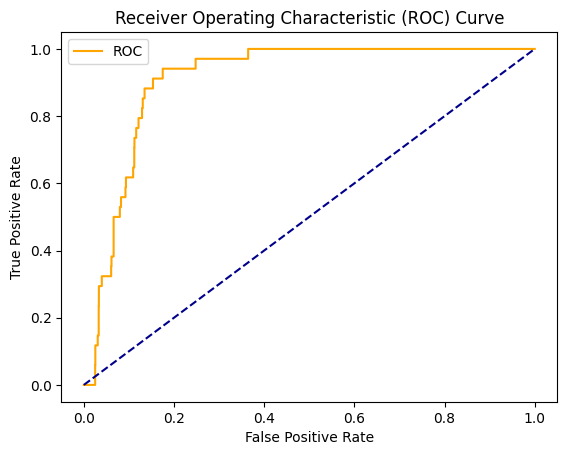

In [204]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = b[0]
y_scores = b[1][:,1]
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [296]:
data2 = pd.read_csv("H.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    #x,label = EditedNearestNeighbours().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.76455,shuffle=False)
    X_train,y_train = RandomOverSampler(random_state=1).fit_resample(X_train,y_train)
    #X_test,y_test = SMOTE().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False),data2,6.5,"sc")

0.68384
{'tn': 997, 'fp': 3, 'fn': 20, 'tp': 5, 'mcc': 0.34532717873583013, 'f1': 0.30303030303030304, 'acc': 0.9775609756097561, 'recall': 0.2, 'precision': 0.625, 'mag': 6.5, 'region': 'sc'}


In [ ]:
data2 = pd.read_csv("H.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    #x,label = EditedNearestNeighbours().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.76455,shuffle=False)
    X_train,y_train = RandomOverSampler(random_state=1).fit_resample(X_train,y_train)
    #X_test,y_test = SMOTE().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False),data2,6.5,"sc")

In [230]:
l = 0.000001
print(confusion_matrix(b[0],threshold(b[1][:,0],l)))
Performance(b[0],threshold(b[1][:,1],l),"6.5","sc")

[[   0 8704]
 [   0   34]]


{'tn': 2619,
 'fp': 6085,
 'fn': 20,
 'tp': 14,
 'mcc': -0.03896230998528463,
 'f1': 0.004565465514430132,
 'acc': 0.3013275349050126,
 'recall': 0.4117647058823529,
 'precision': 0.002295458271847844,
 'mag': '6.5',
 'region': 'sc'}

In [300]:
data = pd.DataFrame(data)
data.columns = data2.columns.copy()

In [304]:
scdata = pd.read_csv(r"C:\Users\12105\Desktop\HZ with gap\raw_data\SC_k.csv")

In [320]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = SMOTEENN().fit_resample(X_train,y_train)
    #X_test,y_test = SMOTEENN().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=50,learning_rate=0.05,max_depth=2),data,5,"sc")

0.8154484172166475
{'tn': 7960, 'fp': 47, 'fn': 1744, 'tp': 312, 'mcc': 0.3171194700759998, 'f1': 0.25838509316770186, 'acc': 0.8220212660240485, 'recall': 0.1517509727626459, 'precision': 0.8690807799442897, 'mag': 5, 'region': 'sc'}


In [350]:
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = SMOTEENN().fit_resample(X_train,y_train)
    #X_test,y_test = SMOTEENN().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=60,learning_rate=0.06,max_depth=2),data,5,"sc")

0.7967553257145135
{'tn': 7943, 'fp': 64, 'fn': 1847, 'tp': 209, 'mcc': 0.23245085859595702, 'f1': 0.1794761700300558, 'acc': 0.8100963927258273, 'recall': 0.10165369649805447, 'precision': 0.7655677655677655, 'mag': 5, 'region': 'sc'}


In [685]:
scdata = pd.read_csv(r"C:\Users\12105\Desktop\HZ with gap\raw_data\SC_k.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = EditedNearestNeighbours().fit_resample(X_train,y_train)
    #X_test,y_test = EditedNearestNeighbours().fit_resample(X_test,y_test)
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=1200,learning_rate=0.05,max_depth=6,eval_metric="MCC",auto_class_weights = "Balanced",),data,5.5,"sc")

0.3717169197509692
{'tn': 9632, 'fp': 236, 'fn': 188, 'tp': 7, 'mcc': 0.010759527668282974, 'f1': 0.03196347031963471, 'acc': 0.9578654476796185, 'recall': 0.035897435897435895, 'precision': 0.02880658436213992, 'mag': 5.5, 'region': 'sc'}


In [532]:
scdata = pd.read_csv(r"C:\Users\12105\Desktop\HZ with gap\raw_data\SC_k.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=0.3,shuffle=False)
    #X_train,y_train = SMOTE().fit_resample(X_train,y_train)
    #X_test,y_test = RandomUnderSampler(random_state=0,sampling_strategy=0.2).fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False),data,6,"sc")

0.5488856325603253
{'tn': 9998, 'fp': 11, 'fn': 54, 'tp': 0, 'mcc': -0.002429806211266083, 'f1': 0.0, 'acc': 0.9935406936301302, 'recall': 0.0, 'precision': 0.0, 'mag': 6, 'region': 'sc'}


In [526]:
l = 0.01
print(confusion_matrix(b[0],threshold(b[1][:,1],l)))
Performance(b[0],threshold(b[1][:,1],l),"6.5","sc")

[[221  49]
 [ 53   1]]


{'tn': 221,
 'fp': 49,
 'fn': 53,
 'tp': 1,
 'mcc': -0.16811535837819142,
 'f1': 0.01923076923076923,
 'acc': 0.6851851851851852,
 'recall': 0.018518518518518517,
 'precision': 0.02,
 'mag': '6.5',
 'region': 'sc'}

In [672]:
data2 = pd.read_csv("CH.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    #x,label = EditedNearestNeighbours().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = RandomOverSampler(random_state=1).fit_resample(X_train,y_train)
    #X_test,y_test = RandomOverSampler().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=2000,max_depth=4,auto_class_weights="Balanced"),data2,6.5,"sc")

0.9238924581132144
{'tn': 1840, 'fp': 119, 'fn': 124, 'tp': 214, 'mcc': 0.5759375132784503, 'f1': 0.6378539493293591, 'acc': 0.8942098389203309, 'recall': 0.6331360946745562, 'precision': 0.6426426426426426, 'mag': 6.5, 'region': 'sc'}


In [738]:
data2 = pd.read_csv("H.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    #x,label = EditedNearestNeighbours().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.75,shuffle=False)
    #X_train,y_train = RandomOverSampler(random_state=1).fit_resample(X_train,y_train)
    #X_test,y_test = RandomOverSampler().fit_resample(X_test,y_test)
    model.fit(X_train[:-20],y_train[:-20])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=500,max_depth=6),data2,5,"sc")

0.4583518730757995
{'tn': 725, 'fp': 90, 'fn': 240, 'tp': 33, 'mcc': 0.014306935424797097, 'f1': 0.16666666666666666, 'acc': 0.6966911764705882, 'recall': 0.12087912087912088, 'precision': 0.2682926829268293, 'mag': 5, 'region': 'sc'}


In [757]:
data2 = pd.read_csv("H.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    #x,label = EditedNearestNeighbours().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = RandomOverSampler(random_state=1).fit_resample(X_train,y_train)
    #X_test,y_test = RandomOverSampler().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    ypr = model.predict_proba(X_test)
    print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result , [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,n_estimators=500,max_depth=6),data2,6.5,"sc")

0.47120136094834336
{'tn': 1277, 'fp': 0, 'fn': 29, 'tp': 0, 'mcc': 0.0, 'f1': 0.0, 'acc': 0.9777947932618682, 'recall': 0.0, 'precision': 0.0, 'mag': 6.5, 'region': 'sc'}


In [785]:
data2 = pd.read_csv("H.csv")
def model_result1(model,geodata,thr_mag,regionname):
    x,y = geodata.iloc[:,:-1],geodata.iloc[:,-1]
    label = threshold(y,thr_mag)
    #x,label = EditedNearestNeighbours().fit_resample(x,label)
    X_train, X_test, y_train, y_test = train_test_split(x,label,test_size=1-0.7,shuffle=False)
    #X_train,y_train = RandomOverSampler(random_state=1).fit_resample(X_train,y_train)
    #X_test,y_test = RandomOverSampler().fit_resample(X_test,y_test)
    model.fit(X_train[:-50],y_train[:-50])
    yhat = model.predict(X_test)
    #ypr = model.predict_proba(X_test)
    #print(roc_auc_score(y_test,ypr[:,1]))
    result = Performance(y_test,yhat,mag=thr_mag,region=regionname)
    print(result)
    return result #, [y_test,ypr]

a, b = model_result1(CatBoostClassifier(verbose=False,has_time=True),data2,5,"sc")

0.42951948997861367
{'tn': 819, 'fp': 120, 'fn': 331, 'tp': 36, 'mcc': -0.04116738012934649, 'f1': 0.13766730401529637, 'acc': 0.6546707503828484, 'recall': 0.09809264305177112, 'precision': 0.23076923076923078, 'mag': 5, 'region': 'sc'}


In [789]:
a  = int(len(data)*0.7)
sum(data.iloc[a:,-1]>5)/len(data[a:])

0.20431282917619